In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

# numpy for working with vector, matrices, etc. 
import numpy as np
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as mtick
from matplotlib import animation, cm

# for working with time and dates
import datetime

# scipy for statistics and optimization
from scipy import stats
from scipy import optimize
from scipy.linalg import block_diag

# Loading data using pandas datareader
from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

# numerical derivatives using statsmodels
from statsmodels.tools.numdiff import approx_fprime, approx_hess

# typehints
from typing import Union, List, Tuple

# cvxopt and cvxpy for optimization 
import cvxopt 
import cvxpy as cp 


"""
Own packages
"""

# nominal yield curve data
from codelib.dal.fred_yield_data import get_nominal_yield_data

# moments: kurtosis with probs, etc. 
from codelib.statistics import moments as mom

# functions for calculating risk budget and portfolio risk metrics 
from codelib.portfolio_optimization import risk_budget as rb 
from codelib.portfolio_optimization import risk_metrics as rm


from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import fitting_error, crem_denoised_corr_mat
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density


from codelib.visualization.base import correlation_plot, fan_chart, risk_waterfall_chart, waterfall_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

# Exercises - Week 6

In this week we will look at a few exercises estimation and estimation uncertainty

## Problem 1: OLS vs. MLE

Consider the regression model

$$
y_i = \alpha + \beta_1 x_{1, i} + \beta_{2, i} x_{2, i} + \varepsilon_i =  \mathbf{x}_i^\top \boldsymbol{\beta} + \varepsilon_i
$$

where $\alpha=1$, $\beta_1 = 1$, and $\beta_2 = 1$. Furthermore, assume that $x_{1, i} \sim  \log N(0, 1)$, $x_{2, i} \sim \log N(0, 1)$ and $\varepsilon_{i} + \xi + \omega \frac{\alpha}{\sqrt{1 + \alpha^2}} \sqrt{2 / \pi} \sim skew normal(\xi, \omega, \alpha)$ with $\xi=0$, $\omega=2$, $\alpha=2$ (we add the mean to make the error term have a mean of zero). The [skew normal](https://en.wikipedia.org/wiki/Skew_normal_distribution) is defined by the density 

$$
f(\varepsilon) = \frac{2}{\omega} \phi(\frac{\varepsilon - \xi}{\omega})\Phi(\alpha\frac{\varepsilon - \xi}{\omega})
$$

__Question 1__

Simulate and estimate the model with OLS 10,000 times for different sample sizes. Plot the kernel density of the estimates. What do you observe, when the sample size increases?

__Question 2__

Simulate and estimate the model with MLE 10,000 times for different sample sizes. Restrict $\xi=0$. Plot the kernel density of the estimates. What do you observe, when the sample size increases?


__Question 3__

Compare the density of the OLS and MLE estimates. Also calculate the standard devation of the OLS estimates. What do you observe? Is this inline with your expectation. 


### Solution 

__Question 1__

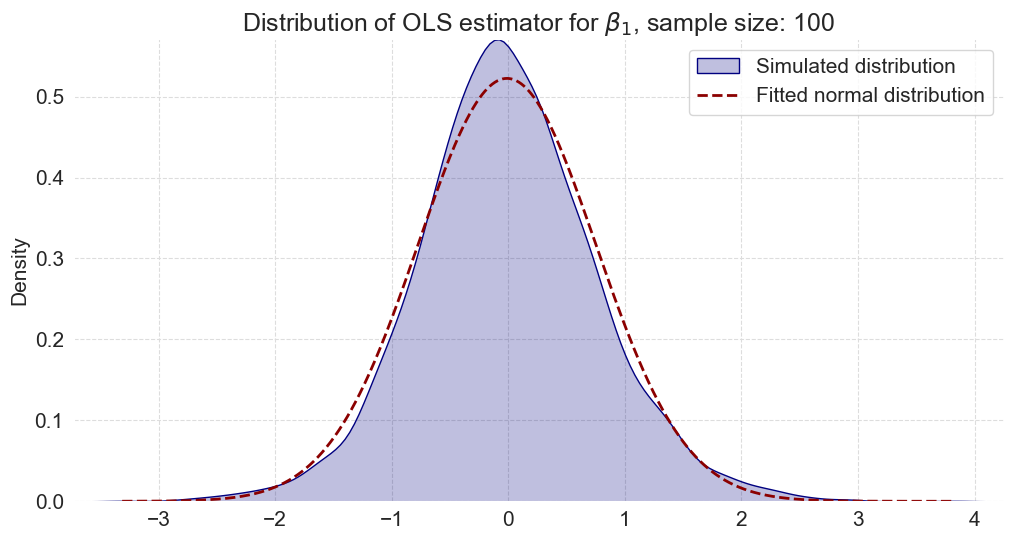

In [2]:
"""
Settings
"""

# number of simulations
num_sim = 4999

# sample size 
sample_size = 100

# true parameter values: constant, beta1, beta2
beta0 = np.array([1.0, 1.0, 1.0])

alpha = 2.0
omega = 2.0
xi = 0.0

"""
Simulations
"""

all_beta_est = np.empty((num_sim, len(beta0)))
for i in range(num_sim): 
    
    # generate independent variables
    x1_sim = stats.lognorm.rvs(1, scale=1, size=sample_size) 
    x2_sim = stats.lognorm.rvs(1, scale=1, size=sample_size)
    x_mat_sim = np.vstack([np.ones(sample_size), x1_sim, x2_sim]).T

    # simulate error term
    eps_sim = stats.skewnorm.rvs(alpha, loc=-omega*alpha / np.sqrt(1 + alpha**2) * np.sqrt(2 / np.pi),
                                 scale=omega, size=sample_size)

    # simulate dependent variable
    y_sim = x_mat_sim @ beta0 + eps_sim
    
    # estimate parameters
    beta_est, res, _, _ = np.linalg.lstsq(x_mat_sim, y_sim, rcond=-1)
    
    all_beta_est[i, :] = beta_est

"""
Plotting
"""
    
idx = 1 # 0: constant, 1: beta1, 2: beta2
param_name_dict = {0: '$\\alpha$', 1: '$\\beta_1$', 2: '$\\beta_2$'}
diff = (all_beta_est[:, idx] - beta0[idx]) * np.sqrt(sample_size)

fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(diff, color="navy", ax=ax, fill=True, alpha=0.25, label="Simulated distribution")

norm_params = stats.norm.fit(diff)

vals_to_eval = np.linspace(min(diff), max(diff), 1000)
ax.plot(vals_to_eval, stats.norm(norm_params[0], norm_params[1]).pdf(vals_to_eval), color="darkred", linestyle="--",
        label="Fitted normal distribution")

ax.set(title="Distribution of OLS estimator for " + param_name_dict[idx] + ", sample size: {}".format(sample_size))

ax.legend();

In [3]:
stats.skewnorm(alpha, loc=-omega*alpha / np.sqrt(1 + alpha**2) * np.sqrt(2 / np.pi),
                                 scale=omega).mean()

np.float64(0.0)

__Question 2__

In [4]:
"""
Define log-likelihood function
"""

def log_like_lin_reg(params, y, x, individual=False):
    
    beta = params[:3]
    alpha = params[3]
    omega = params[4]
    
    loc = -omega * alpha / np.sqrt(1 + alpha**2) * np.sqrt(2 / np.pi)
    
    eps = y - x @ beta
    
    log_like = stats.skewnorm.logpdf(eps, a=alpha, scale=omega, loc=loc)
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)

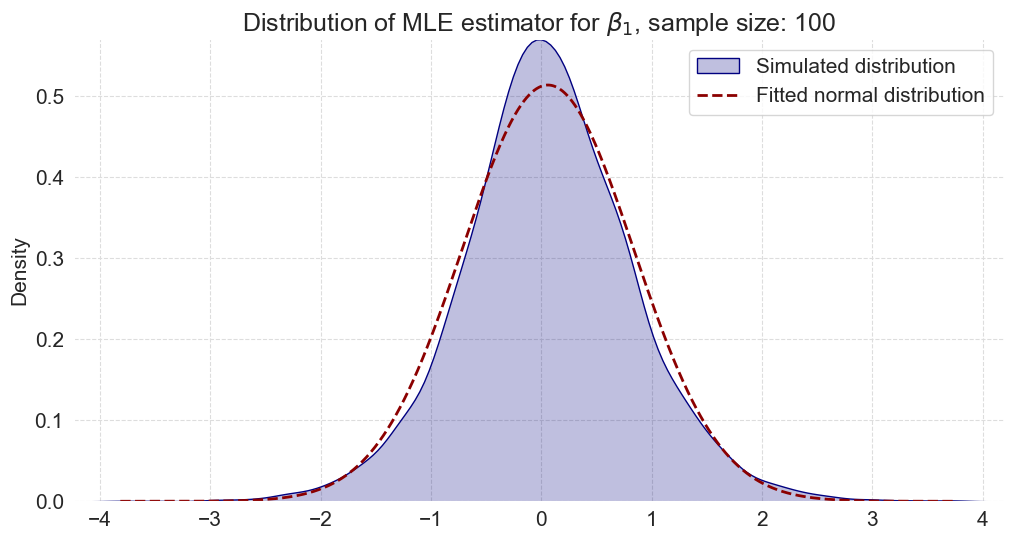

In [5]:
"""
Settings
"""

# number of simulations
num_sim = 4999

# sample size 
sample_size = 100

# true parameter values: constant, beta1, beta2
beta0 = np.array([1.0, 1.0, 1.0])

"""
Simulations
"""

all_beta_est_mle = np.empty((num_sim, len(beta0) + 2))
for i in range(num_sim): 
    
    # generate independent variables
    x1_sim = stats.lognorm.rvs(1, scale=1, size=sample_size) 
    x2_sim = stats.lognorm.rvs(1, scale=1, size=sample_size)
    x_mat_sim = np.vstack([np.ones(sample_size), x1_sim, x2_sim]).T

    # simulate error term
    eps_sim = stats.skewnorm.rvs(alpha, loc=-omega*alpha / np.sqrt(1 + alpha**2) * np.sqrt(2 / np.pi),
                                 scale=omega, size=sample_size)

    # simulate dependent variable
    y_sim = x_mat_sim @ beta0 + eps_sim
    
    # estimate parameters
    res = optimize.minimize(log_like_lin_reg, [1.0, 1.0, 1.0, 1.5, 1.5],
                            args=(y_sim, x_mat_sim),
                            bounds=((-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf),
                                    (0.5, np.inf), (0.5, np.inf))) # add some reasonable constraints
    
    # store parameter estimates
    all_beta_est_mle[i, :] = res.x

"""
Plotting
"""
    
idx = 1 # 0: constant, 1: beta1, 2: beta2
param_name_dict = {0: '$\\alpha$', 1: '$\\beta_1$', 2: '$\\beta_2$'}
diff = (all_beta_est_mle[:, idx] - beta0[idx]) * np.sqrt(sample_size)

fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(diff, color="navy", ax=ax, fill=True, alpha=0.25, label="Simulated distribution")

norm_params = stats.norm.fit(diff)

vals_to_eval = np.linspace(min(diff), max(diff), 1000)
ax.plot(vals_to_eval, stats.norm(norm_params[0], norm_params[1]).pdf(vals_to_eval), color="darkred", linestyle="--",
        label="Fitted normal distribution")

ax.set(title="Distribution of MLE estimator for " + param_name_dict[idx] + ", sample size: {}".format(sample_size))

ax.legend();

__Question 3__

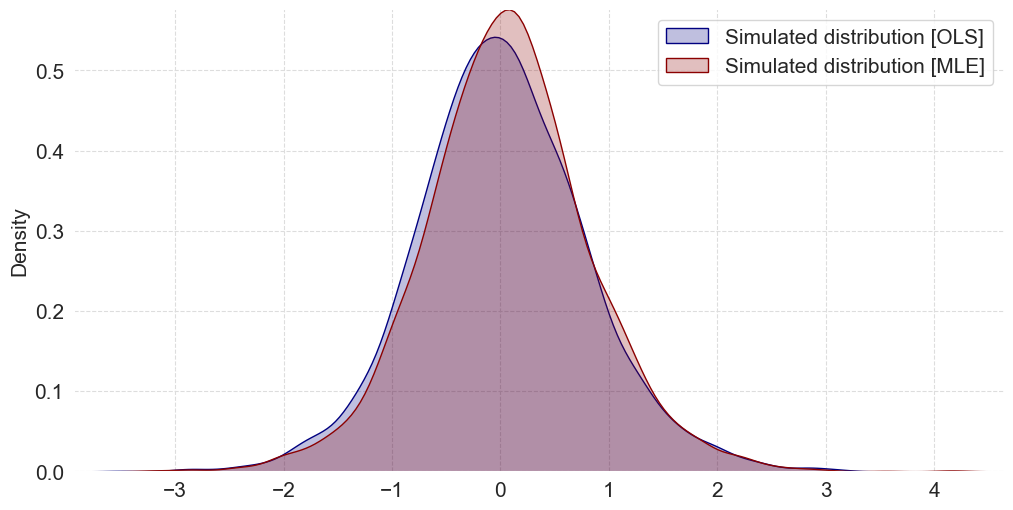

In [6]:
idx = 2

fig, ax = plt.subplots(figsize=(12, 6))
diff_ols = (all_beta_est[:, idx] - beta0[idx]) * np.sqrt(sample_size)
sns.kdeplot(diff_ols, color="navy", ax=ax, fill=True, alpha=0.25, label="Simulated distribution [OLS]")

diff_mle = (all_beta_est_mle[:, idx] - beta0[idx]) * np.sqrt(sample_size)
sns.kdeplot(diff_mle, color="darkred", ax=ax, fill=True, alpha=0.25, label="Simulated distribution [MLE]")

ax.legend();

In [7]:
diff_mle.std()

np.float64(0.7681642018670506)

In [8]:
diff_ols.std()

np.float64(0.786316555663947)

## Problem 2: Recession forecasting [optional]

__Note:__ We follow the exposition of [Nyberg (2010)](https://onlinelibrary-wiley-com.esc-web.lib.cbs.dk:8443/doi/abs/10.1002/for.1161)

In this exercise, we will explore a simple model for forecasting US recessions. Among other things, we will look at the evidence for the yield spread being a predictor of recessions as often mentioned in financial news (and the academic literature).

We are interested in prediciting the recession indicator $y_t, \; t=1,..., T$ which is a binary dependent variable that is defined by

$$
y_t = \left\{ \begin{matrix}
                1, & \text{if the economy is in a recessionary state at time } t \\
                0, & \text{if the economy is in a expansionary state at time } t
              \end{matrix}  \right.
$$

The probability of the dependent variable taking the value $1$ is given by $p_t$ specified as

$$
p_t = \text{Prob}_{t-1}[y_t = 1] = \Phi(\pi_{t})
$$

where $\Phi()$ is the cdf of a standard normal. $\pi_{t}$ is included in the information set at time $t-1$. This model is known as a [Probit model](https://en.wikipedia.org/wiki/Probit_model).

A model not taking the dynamic structure into account is given by the static formulation ($k \leq 1$ must be larger than the forecast horizon)

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta
$$

A dynamic structure can be implemented as ($l \leq 1$)

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l}
$$

A dynamic autoregressive model can be implemented as

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l} + \alpha \pi_{t-1}
$$

__Question 1__

Get recession indicators ('USREC') and yield spread ('T10YFF') from the FRED database from the beginning of 1983. Plot the yield spread together with the recession indicators.

__Question 2__

First, we will consider a model where we solely use the yield spread (and a constant) to predict recessions. To that end, we need to define the likelihood function.

The conditional probability function is given by

$$
f_{Y_t}(y_t \vert \mathbf{x}_t, \mathbf{x}_{t-1},..., y_{t-1},...; \theta)   = p_t^{y_t} (1 - p_t)^{1 - y_t} = \Phi(\pi_{t})^{y_t} (1 - \Phi(\pi_{t}))^{1 - y_t}
$$

We can therefore write the (conditional) likelihood function as

$$
L_T(\theta) = \prod_{t=1}^T \Phi(\pi_{t})^{y_t} (1 - \Phi(\pi_{t}))^{1 - y_t}
$$


and the log-likelihood function as

$$
\mathcal{L}_{T}(\theta) = \sum_{t=1}^T q_t(y_t, \mathbf{x}_t; \theta) = \sum_{t=1}^T \left[y_t \ln \Phi(\pi_{t}) + (1-y_t) \ln (1 - \Phi(\pi_{t}))  \right]
$$

Assume that $\pi_{t} = \mathbf{x}_{t-k}^\top \beta$ with $\mathbf{x}_{t-k} = [1, ys_{t-k}]^\top$ where $ys_{t}$ is the yield-spread at time $t$. Consider $k=6$. Estimate the model using maximum-likelihood.


__Question 3__

Derive the expressions for

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n  \frac{\partial^2 q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta \partial \theta^\top}  \\
\frac{1}{n} \sum_{i=1}^n \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta } \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta^\top }
\end{align}
$$
when considering the static model. It may be usefull to remember that

$$
\frac{\partial \Phi(\pi_t)}{\partial \theta} = \phi(\pi_t) \frac{\partial \pi_t}{\partial \theta}  = \phi(\pi_t) \mathbf{x}_{t-k}
$$

where $\phi(\pi_t)$ is the density of a standard normal and

$$
\frac{\partial \phi(\pi_t)}{\partial \theta} = -\phi(\pi_t) \pi_t \frac{\partial \pi_t}{\partial \theta}
$$

Implement functions that calculate these quantities.

__Question 4__

Calculate the standard errors analytically and numerically.

__Quesiton 5__

Check the results using `statsmodels`. Are the parameters significant at a 5\% significance level?

__Question 6__

Implement and estimate the dynamic model.

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l}
$$

__Question 7__

Implement and estimate the autoregressive model.

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta  + \alpha \pi_{t-1}
$$

__Note:__ We have only considered in-sample results which may not work out-of-sample.

### Solution

__Question 1__


In [40]:
df_data = DataReader(['USREC', 'T10YFF', 'T10Y3M'], 'fred', start=datetime.date(1983,1,1))

In [41]:
df_data

,USREC,T10YFF,T10Y3M
DATE,,,
1983-01-01,0.0,NaN,NaN
1983-01-03,NaN,1.13,2.15
1983-01-04,NaN,0.90,2.09
1983-01-05,NaN,1.89,2.10
1983-01-06,NaN,1.91,2.19
...,...,...,...
2025-10-01,NaN,0.03,0.11
2025-10-02,NaN,0.01,0.08
2025-10-03,NaN,0.04,0.10


In [43]:
df_data_monthly = df_data.resample('ME').first().dropna()
df_data_monthly.index = df_data['USREC'].dropna().index

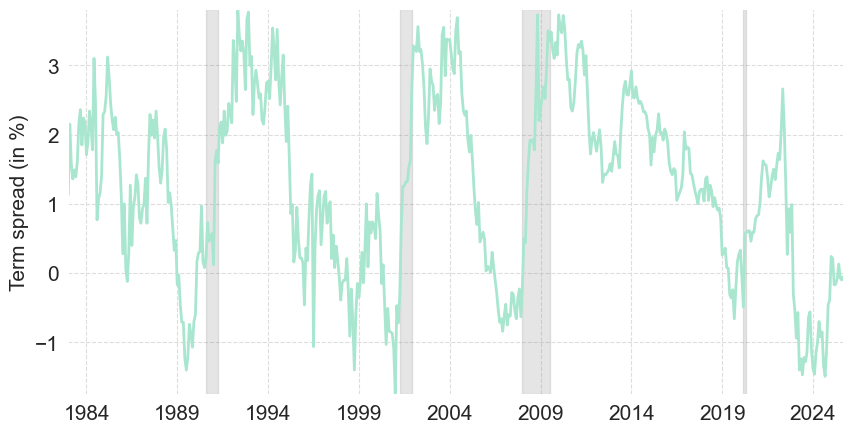

In [44]:
nber_recessions = df_data_monthly['USREC'].dropna()

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax = df_data_monthly['T10YFF'].plot(figsize=(10,5));
ax.set_ylabel('Term spread (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)

__Question 2__

First, we implement the log-likelihood function

In [45]:
"""
Log-likelihood function
"""

def log_like_probit(beta, y, x, individual=False):

    pi = x @ beta
    prob = stats.norm.cdf(pi)

    log_like = y * np.log(prob) + (1-y) * np.log(1 - prob)

    if individual:
        return -log_like
    else:
        return -np.sum(log_like)

Next, we select the data which we want to use

In [46]:
k = 6
y_data = df_data_monthly['USREC'].values[k:]
x_data = df_data_monthly['T10YFF'].values[:-k] / 100
x_data = np.c_[np.ones_like(x_data), x_data]

In [48]:
"""
Minimize negative log-likelihood
"""
res = optimize.minimize(log_like_probit, [0.13,0.0], args=(y_data, x_data))
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 120.19808885964764
        x: [-1.194e+00 -2.961e+01]
      nit: 14
      jac: [ 1.907e-06  0.000e+00]
 hess_inv: [[ 1.019e-02 -3.502e-01]
            [-3.502e-01  4.924e+01]]
     nfev: 45
     njev: 15

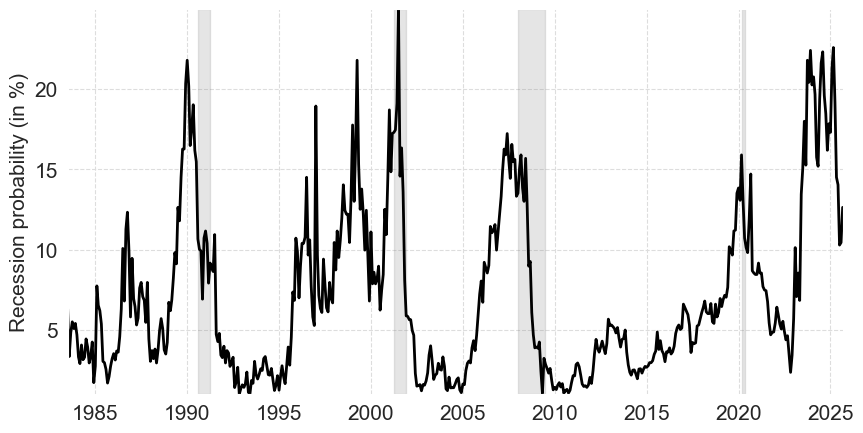

In [49]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, stats.norm.cdf(x_data @ res.x) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)


__Question 3__

We note that

$$
q_t(y_t, \mathbf{x}_t; \theta) = y_t \ln \Phi(\pi_{t}) + (1-y_t) \ln (1 - \Phi(\pi_{t}))
$$

First, we find the gradient (using the chain-rule, derivative of natural logarithm, fundamental theorem of calculus, etc.)

$$
\begin{align}
\frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta} &= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \frac{\partial \Phi(\pi_{t})}{\partial \theta}\\
&= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\frac{\partial \pi_{t}}{\partial \theta} \\
&= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t
\end{align}
$$

Implying that

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta } \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta^\top }  = \frac{1}{n} \sum_{i=1}^n \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right]^2 \phi(\pi_{t})^2\mathbf{x}_t\mathbf{x}_t^\top
\end{align}
$$

The Hessian is given by

$$
\begin{align}
\frac{\partial^2 q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta \partial \theta^\top} &= \frac{\partial}{\partial \theta}\left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t^\top \\
&= \left[\frac{\partial}{\partial \theta}\left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t^\top \right] + \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \frac{\partial}{\partial \theta}\phi(\pi_{t})\mathbf{x}_t^\top \\
&=\left[-y_t \frac{1}{\Phi(\pi_{t})^2} - (1-y_t) \frac{1}{(1 -\Phi(\pi_{t}))^2} \right] \phi(\pi_{t})\mathbf{x}_t\phi(\pi_{t})\mathbf{x}_t^\top - \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right]  \phi(\pi_{t}) \mathbf{x}_t^\top \beta \mathbf{x}_t \mathbf{x}_t^\top \\
&=-\left[y_t \frac{\phi(\pi_{t}) + \mathbf{x}_t^\top \beta \Phi(\pi_{t})}{\Phi(\pi_{t})^2} + (1-y_t) \frac{\phi(\pi_{t}) - (1 -\Phi(\pi_{t}))\mathbf{x}_t^\top \beta}{(1 -\Phi(\pi_{t}))^2} \right] \phi(\pi_{t})\mathbf{x}_t\mathbf{x}_t^\top
\end{align}
$$

Below, we implement the expressions.

In [50]:
"""
Gradient (outer product of the scores)
"""

def outer_gradient(theta, x, y):

    pi = x @ theta
    pdf_vals = stats.norm.pdf(pi)
    cdf_vals = stats.norm.cdf(pi)

    first_part = (y * (1 / cdf_vals) - (1 - y) * (1 / (1-cdf_vals)))**2 * pdf_vals**2

    return np.sum(first_part[:, None, None] * np.einsum('ji,jk->jik', x, x), axis=0)


"""
Hessian
"""

def hessian(theta, x, y):

    pi = x @ theta
    pdf_vals = stats.norm.pdf(pi)
    cdf_vals = stats.norm.cdf(pi)

    first_part = (-(y * (pdf_vals + pi * cdf_vals) / (cdf_vals**2) +
                   (1 - y) * (pdf_vals - pi * (1 - cdf_vals)) / ((1-cdf_vals)**2)) * pdf_vals)

    return np.sum(first_part[:, None, None] * np.einsum('ji,jk->jik',x, x), axis=0)

__Question 5__

In [51]:
params_mle = res.x
A = hessian(params_mle, x_data, y_data)
B = outer_gradient(params_mle, x_data, y_data)

param_mle_cov_A = np.linalg.inv(-A)

param_mle_cov_B = np.linalg.inv(B)

param_mle_cov_sandwich = np.linalg.inv(A) @ B @ np.linalg.inv(A)

In [52]:
# covariance matrix based on A
param_mle_cov_A

array([[ 1.01695670e-02, -3.47313387e-01],
       [-3.47313387e-01,  4.93727631e+01]])

In [53]:
# covariance matrix based on B
param_mle_cov_B

array([[ 1.00090106e-02, -3.23834045e-01],
       [-3.23834045e-01,  4.59421009e+01]])

In [54]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich

array([[ 1.03421260e-02, -3.72546466e-01],
       [-3.72546466e-01,  5.30596691e+01]])

In [55]:
# sandwich standard errors
np.sqrt(np.diag(param_mle_cov_sandwich))

array([0.10169624, 7.28420682])

In [56]:
"""
Numerical scores
"""

scores = approx_fprime(params_mle, log_like_probit, args=(y_data, x_data, True))
B_approx = scores.T @ scores

A_approx = -approx_hess(params_mle, log_like_probit, args=(y_data, x_data))

param_mle_cov_A_num = np.linalg.inv(-A_approx)

param_mle_cov_B_num = np.linalg.inv(B_approx)

param_mle_cov_sandwich_num = np.linalg.inv(A_approx) @ B_approx @ np.linalg.inv(A_approx)

In [57]:
# covariance matrix based on A
param_mle_cov_A_num

array([[ 1.01695670e-02, -3.47313390e-01],
       [-3.47313390e-01,  4.93727636e+01]])

In [58]:
# covariance matrix based on B
param_mle_cov_B_num

array([[ 1.00090106e-02, -3.23834047e-01],
       [-3.23834047e-01,  4.59421008e+01]])

In [59]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich_num

array([[ 1.03421260e-02, -3.72546470e-01],
       [-3.72546470e-01,  5.30596702e+01]])

In [60]:
# sandwich standard errors
np.sqrt(np.diag(param_mle_cov_sandwich_num))

array([0.10169624, 7.2842069 ])

__Question 6__

Yes, both the constant and the term spread is highly signficant.

Luckily, we get the same results as `statsmodels`.

In [61]:
import statsmodels.api as sm

stat_est = sm.Probit(y_data, x_data).fit(cov_type='HC0')
stat_est.summary()

Optimization terminated successfully.
         Current function value: 0.237077
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  507
Model:                         Probit   Df Residuals:                      505
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Oct 2025   Pseudo R-squ.:                 0.07476
Time:                        20:33:42   Log-Likelihood:                -120.20
converged:                       True   LL-Null:                       -129.91
Covariance Type:                  HC0   LLR p-value:                 1.047e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1937      0.102    -11.738      0.000      -1.393      -0.994
x1           -29.6149      7.284     -4.066      0.000     -43.892     -15.338
==============================================================================
"""

__Question 6__

In [62]:
x_dynamic_data = np.c_[x_data, df_data_monthly['USREC'].values[k-1:-1]]

In [63]:
res_dynamic = optimize.minimize(log_like_probit, [0.0,0.0, 0.0], args=(y_data, x_dynamic_data))
res_dynamic

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 31.387893972261878
        x: [-2.166e+00 -3.969e+01  3.716e+00]
      nit: 24
      jac: [-2.384e-07  2.384e-07 -1.431e-06]
 hess_inv: [[ 3.999e-02 -2.661e-02 -3.971e-02]
            [-2.661e-02  2.365e+02 -2.375e+00]
            [-3.971e-02 -2.375e+00  1.455e-01]]
     nfev: 100
     njev: 25

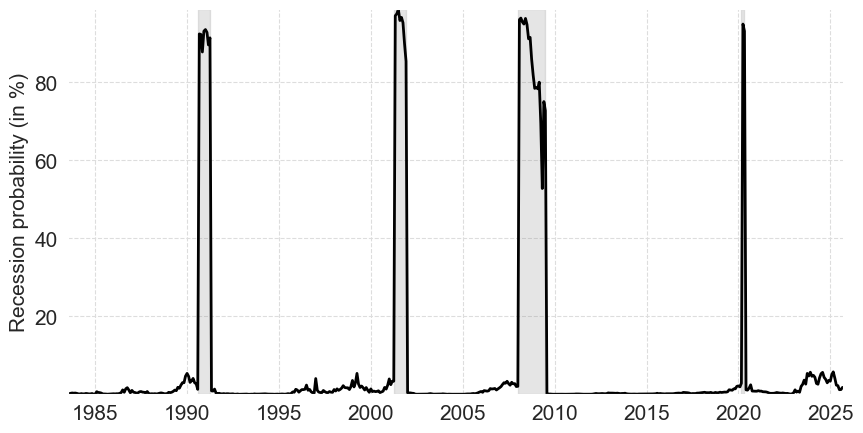

In [64]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, stats.norm.cdf(x_dynamic_data @ res_dynamic.x) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)


__Question 7__

In [65]:
"""
Log-likelihood function
"""

def calculate_recession_probs(theta, x):

    beta = theta[:-1]
    alpha = theta[-1]

    pi = x @ beta
    for i in range(1, len(x)):
        pi[i] += alpha * pi[i-1]

    prob = stats.norm.cdf(pi)
    return prob

def log_like_autoregressiv_probit(theta, y, x, individual=False):

    prob = calculate_recession_probs(theta, x)

    log_like = y * np.log(prob) + (1-y) * np.log(1 - prob)

    if individual:
        return -log_like
    else:
        return -np.sum(log_like)


In [66]:
theta_init = [ -1.03667616, -4.831408, 0.7]
res_auto = optimize.minimize(log_like_autoregressiv_probit, theta_init,
                             args=(y_data, x_data),
                             method='L-BFGS-B',
                             #approx_grad=True,
                             #options={'eps': 1e-06,
                             #        'maxls':10},
                             options= {"gtol": 1e-6, "ftol": 1e-16, "maxfun": 30000, "maxiter": 30000, "maxls": 40},
                             bounds = ((None, None), (None, None),(0.0, 0.95)))
res_auto

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 92.37403890464154
        x: [-3.870e-02 -8.735e+00  9.325e-01]
      nit: 38
      jac: [ 1.549e-04  2.842e-06 -1.606e-04]
     nfev: 224
     njev: 56
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

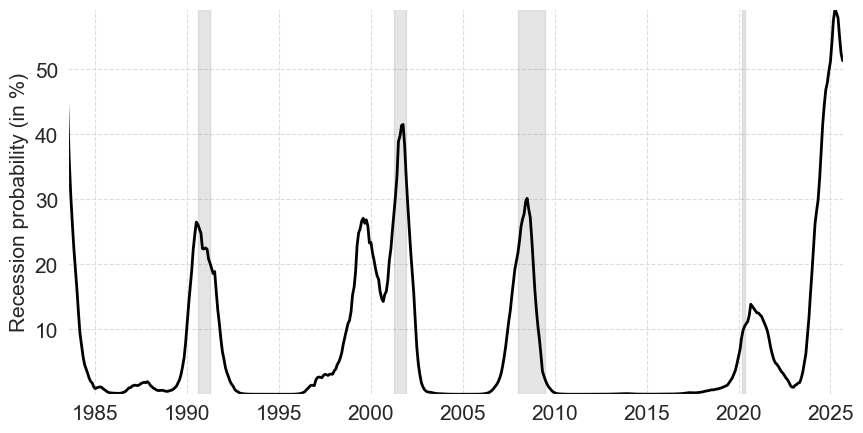

In [67]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, calculate_recession_probs(res_auto.x, x_data) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)

## Problem 3: MLE and hypothesis testing [optional]

Consider the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

$$
f_{y}(y; \theta) = \frac{\beta^\rho}{\Gamma(\rho)} y^{\rho -1} e^{-y \beta}
$$
where $\theta = (\beta, \rho)^\top$, $\Gamma(\rho)$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function).

__Question 1__

Simulate 1,000 observations assuming $\beta = 1$ and $\rho=1$ from a gamma distribution. Plot the histogram together with the true density.

__Question 2__

Define the log-likelihood function and estimate the parameters. Note that the functions `scipy.special.gamma`, `scipy.special.gammaln`, and `scipy.special.digamma` ([digamma function](https://en.wikipedia.org/wiki/Digamma_function)) may be relevant.

__Question 3__

The gradiant is given by

$$
\frac{\partial q_i(y_i ;\theta)}{\partial \theta } = \begin{bmatrix} \rho \frac{1}{\beta} - y_i \\ \ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i\end{bmatrix}\\
$$

and therefore

$$
\frac{\partial q_i(y_i ;\theta)}{\partial \theta } \frac{\partial q_i(y_i ;\theta)}{\partial \theta^\top } = \begin{bmatrix} \rho \frac{1}{\beta} - y_i \\ \ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i\end{bmatrix}\begin{bmatrix} \rho \frac{1}{\beta} - y_i \\ \ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i\end{bmatrix}^\top = \begin{bmatrix} (\rho \frac{1}{\beta} - y_i)^2 & (\rho \frac{1}{\beta} - y_i) (\ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i) \\
(\rho \frac{1}{\beta} - y_i) (\ln \beta - \frac{d \ln \Gamma (\rho)}{d \rho} + \ln y_i) & (\ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i)^2 \end{bmatrix}
$$

and the Hessian is given by

$$
\frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top } = \begin{bmatrix} \frac{-\rho}{\beta^2}  & \frac{1}{\beta} \\
\frac{1}{\beta} & - \frac{d^2 \ln \Gamma (\rho)}{d \rho^2} \end{bmatrix}
$$

Define a function that returns

$$
\sum_{i=1}^n\frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top} = \sum_{i=1}^n \text{E} \left[ \frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top} \right] = \sum_{i=1}^n \begin{bmatrix} \frac{-\rho}{\beta^2}  & \frac{1}{\beta} \\
\frac{1}{\beta} & - \frac{d^2 \ln \Gamma (\rho)}{d \rho^2} \end{bmatrix}
$$


__Question 4__

We remember that

$$
\hat{\theta}_{MLE} \sim^a N\left(\theta_0, -\left[ \sum_{i=1}^n \text{E} \left[ \left. \frac{\partial^2 q_i(y_i ;\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right]^{-1}\right)
$$

Since $\theta_0$ (in real life) is unkown, then we replace it with the obtained estimate. Calculate the standard errors of the estimator.

__Question 5__

The MLE follows a multivariate normal distribution in the limit (for simplicity let $\mathbf{V}$ denote the asymptotic variance)

$$
\hat{\theta} \sim^a N(\theta_0, \mathbf{V})
$$

If we let $\mathbf{R}$ be a $(q \times k)$ matrix and $\mathbf{r}$ be a $q \times 1$ vector where $q$ is the number of restrictions and $k$ is the number of parameters (so 2 in the model we are considering here).

Assuming the null hypothesis

$$
\text{H}_0 : \mathbf{R} \theta - \mathbf{r} = \mathbf{0}
$$

we will have (under the null hypothesis)

$$
\mathbf{R} \hat{\theta} - \mathbf{r} \sim^a N(\mathbf{0}, \mathbf{R}\mathbf{V}\mathbf{R}^\top)
$$

When testing a single hypothesis ($q=1$), we will have

$$
\frac{\mathbf{R} \hat{\theta} - \mathbf{r}}{\sqrt{\mathbf{R}\mathbf{V}\mathbf{R}^\top}} \sim^a N(0, 1)
$$

If we want to test the hypothesis $\text{H}_0: \beta=1$ vs. the alternative $\text{H}_A: \beta \neq 1$ in the model considered here, we simple choose $\mathbf{R} = [0, 1]$ and $\mathbf{r} = 1$ such that

$$
Z = \frac{\mathbf{R} \hat{\theta} - \mathbf{r}}{\sqrt{\mathbf{R}\mathbf{V}\mathbf{R}^\top}} = \frac{\hat{\beta} -  1}{\sqrt{V_{11}}} = \frac{\hat{\beta} -  1}{\sqrt{\text{Var}(\hat{\beta})}}  \sim^a N(0, 1)
$$

which is the well-known test statistic. We obtain the (two-side) $p$-value as $2 (1 - \Phi(\vert z \vert))$.

Test the hypotheses that (one at the time) that $\beta=1$ and $\rho=1$.


__Question 6__

We now want to test the joint hypothesis $\text{H}_0: \beta=1, \rho=1$ vs. the alternative $\text{H}_A: \beta \neq 1, \rho \neq 1$.

To test this hypothesis, we have different possibilities:

* The likelihood ratio test
* The Wald test
* The Lagrange multiplier test

__The likelihood ratio test__

The basic idea is that we have some valid restrictions, say $\mathbf{c}(\theta) = \mathbf{r}$, then imposing it should not lead to a large reduction in the log-likelihood function. It is possible to show that the Likehood Ratio (LR) test statistic

$$
LR = - 2 (\ln L_n^R - \ln L_n^U) \sim \chi^2 (q)
$$

follows a chi-squared distribution with degrees of freedom equal to the number of restrictions, $q$. $L_n^R$ is the restricted likelihood function and $L_n^U$ is the unrestricted likelihood function.

__The Wald test__

If the restrictions are valid, then $\mathbf{c}(\hat{\theta}) - \mathbf{r}$ should be close to zero since the MLE is consistent. The wald test is based on $\mathbf{c}(\hat{\theta}) - \mathbf{r}$ and we will reject the hypothesis if this value is significantly different from zero. The wald test statistc can be written as

$$
W = [\mathbf{c}\left(\hat{\theta}\right) - \mathbf{r}]^\top \left(\mathbf{C} \mathbf{V} \mathbf{C}^\top \right)^{-1} [\mathbf{c}\left(\hat{\theta}\right) - \mathbf{r}] \sim \chi^2 (q)
$$
where $\mathbf{C} = \left. \frac{\partial \mathbf{c}(\theta)}{\partial \theta^\top} \right \vert_{\theta=\hat{\theta}}$.  For linear restrictions $\mathbf{R} \theta - \mathbf{r}$, we will have

$$
W = [\mathbf{R} \hat{\theta} - \mathbf{r}]^\top \left(\mathbf{R} \mathbf{V} \mathbf{R}^\top \right)^{-1} [\mathbf{R} \hat{\theta} - \mathbf{r}] \sim \chi^2 (q)
$$

__The Lagrange multiplier test__

As the name entails, the test is related to the Lagrangian of the constrained problem

$$
\mathcal{L}^*_n(\theta) = \mathcal{L}_n (\theta) + \lambda^\top (\mathbf{c}(\theta) - \mathbf{r})
$$

The solution to this constrained problem satisfies the the first order conditions

$$
\begin{align}
\frac{\partial \mathcal{L}_n^* (\theta)}{\partial \theta}&=\frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} + \mathbf{C}^\top \lambda = \mathbf{0}\\
\frac{\partial \mathcal{L}_n^* (\theta)}{\partial \lambda}&= \mathbf{c}(\theta) - \mathbf{r} = \mathbf{0}
\end{align}
$$

The restrictions not being binding corresponds to $\lambda = \mathbf{0}$ why we may define the null hypothesis as $\text{H}_0: \lambda= \mathbf{0}$ (i.e. the lagrange multiplier being equal to zero). A more common approach is obtained by noting that evaluated at the restricted estimate, then the score should be close to zero

$$
\hat{\mathbf{g}}_R = \left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} \right \vert_{\theta = \hat{\theta}_R} = \hat{\mathbf{C}}^\top \lambda = \mathbf{0}
$$

Under the nulll hypothesis the Lagrange Multiplier test statistic

$$
\left[\left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} \right \vert_{\theta = \hat{\theta}_R}  \right]^\top    \mathbf{V}_R \left[ \left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta} \right \vert_{\theta = \hat{\theta}_R} \right] \sim \chi^2 (q)
$$

where $\mathbf{V}_R $ is the asymptotic variance of the restricted model. One advantage of the LM test is that we only need to estimate the model under the null hypothesis!

Implement all the three above tests.

__Question 7__


[_Size_](https://en.wikipedia.org/wiki/Size_(statistics)) and [_power_](https://en.wikipedia.org/wiki/Power_of_a_test) are two key properties of a test.  Size is the probability of commiting a type I error, i.e. rejecting a true null hypothesis and power is the probability of rejecting a false null hypothesis.

The distributions used above for testing hypotheses about the parameters rely on asymptotic theory, but this may be a bad approximation in small samples.

For different sample sizes, e.g. 100, 250, 500, 1000, using at least 10,000 simulated samples check how well the LR test statistic from a above follows a $\chi^2(q)$ distribution.

__Question 8__

How often does the LR-statistic exceed the 5\% critical value for each of the sample sizes?

__Question 9__

We want to examine the power of the LR test. To calculate the probability of rejecting the null hypothesis (we keep the one from above) given that it is false, then we need to assume some true alternative. We will assume that $\beta=1.25$. Redo the simulation and calculate how many times LR-statistic exceed the 5\% critical value for each of the sample sizes.




### Solution

__Question 1__

In [68]:
n = 1000
beta_true = 1.0
rho_true = 1.0
y_data = stats.gamma.rvs(a=rho_true, scale=1.0/beta_true, size=n)

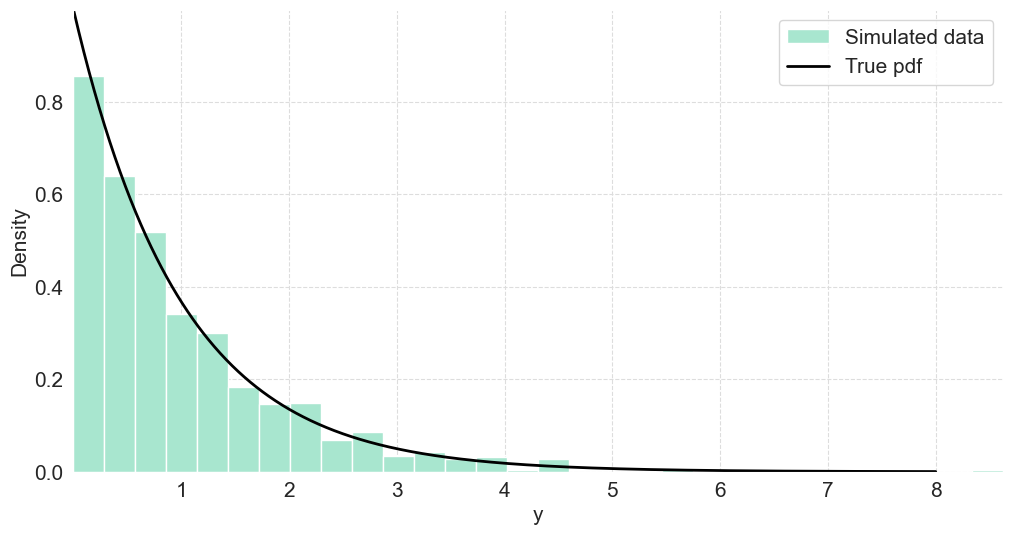

In [69]:
# density
y_vals = np.linspace(0.001, 8.0, 1000)
pdf_vals = stats.gamma.pdf(y_vals, a=rho_true, scale=1.0/beta_true)

# plotting
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(y_data, bins=30, density=True, label="Simulated data")
ax.plot(y_vals, pdf_vals, color="black", label="True pdf")

ax.set_xlabel("y")
ax.set_ylabel("Density")
ax.legend();

__Question 2__

The likelihood function can be written as

$$
L_n(\theta) = \prod_{i=1}^n \frac{\beta^\rho}{\Gamma(\rho)} y_i^{\rho -1} e^{-y_i \beta}
$$

Taking the natural logarithm yields

$$
\mathcal{L}_{n}(\theta) = \sum_{i=1}^n q_i(y_i; \theta) = \sum_{i=1}^n \left[\rho \ln \beta - \ln \Gamma (\rho) + (\rho - 1) \ln y_i - y_i \beta \right] = n \left[\rho \ln \beta - \ln \Gamma (\rho) \right] + \sum_{i=1}^n \left[(\rho - 1) \ln y_i - y_i \beta \right]
$$



In [70]:
from scipy.special import gamma, gammaln, psi, polygamma

"""
Define log-likelihood
"""

def log_like_gamma(theta, y,  individual=False):

    beta = theta[0]
    rho = theta[1]

    log_like = rho * np.log(beta) - gammaln(rho) + (rho - 1) * np.log(y) - y * beta

    if individual:
        return -log_like
    else:
        return -np.sum(log_like)


"""
Minimize negative log-like
"""
res = optimize.minimize(log_like_gamma, [1.0, 1.0], args=(y_data, ))
params_mle = res.x

__Question 3__


In [71]:
def gamma_log_like_hessian(theta: np.ndarray, y: np.ndarray):

    """
    Calculates the Hessian of the log-likelihood function
    """

    beta = theta[0]
    rho = theta[1]
    n = len(y)

    hess = np.array([[-rho / (beta**2), 1.0 / beta], [1.0 / beta, - polygamma(1, rho)]])

    return n * hess

__Question 4__



In [72]:
A = gamma_log_like_hessian(params_mle, y_data)
V = -np.linalg.inv(A)
np.sqrt(np.diag(V))

array([0.04903644, 0.03865507])

__Question 5__

In [73]:
"""
Testing beta=1
"""

z_beta = (params_mle[0] - 1.0) / np.sqrt(V[0,0])

p_value_beta =  2.0*(1.0 - stats.norm.cdf(np.abs(z_beta)))
p_value_beta

np.float64(0.5219213917770547)

In [74]:
"""
Testing rho=1
"""

z_rho = (params_mle[1] - 1.0) / np.sqrt(V[1,1])

p_value_rho =  2.0*(1.0 - stats.norm.cdf(np.abs(z_rho)))
p_value_rho

np.float64(0.6628878153935678)

__Question 6__



In [75]:
"""
LR test
"""

like_ratio = 2 * (log_like_gamma([1.0, 1.0], y_data) -
                  log_like_gamma(params_mle, y_data))

p_val_lr = 1 - stats.chi2.cdf(like_ratio, 2)

print("LR: " + str(like_ratio))
print("p-value: " + str(p_val_lr))

LR: 0.4111611530065602
p-value: 0.8141744885906885


In [76]:
"""
Wald test
"""
R = np.eye(2)
r = np.ones(2)
constraint = (R @ params_mle - r)
cov_inv = np.linalg.inv(R @ V @ R.T)

wald = constraint.T @ cov_inv @ constraint
p_val_wald = 1 - stats.chi2.cdf(wald, 2)

print("Wald: " + str(wald))
print("p-value: " + str(p_val_wald))

Wald: 0.419597776105896
p-value: 0.8107472805396942


In [77]:
"""
Lagrange Multiplier test
"""

# get covariance matrix of restricted model
A_res = gamma_log_like_hessian([1.0, 1.0], y_data)
V_res = -np.linalg.inv(A_res)
np.sqrt(np.diag(V))

# define a function calculating the score (we could also do this numerically)
def gamma_log_like_score(theta: np.ndarray, y: np.ndarray, individual=False):

    """
    Calculates the score of the log-likelihood function
    """

    beta = theta[0]
    rho = theta[1]
    n = len(y)

    score_beta = rho / beta - y
    score_rho = np.log(rho) -  polygamma(0, rho) + np.log(y)
    score = np.column_stack((score_beta, score_rho))

    if individual:

        return score

    else:

        return np.sum(score, axis=0)

# calculate score
score_restricted = gamma_log_like_score([1.0, 1.0], y_data, individual=False)

# LM stat
lm = score_restricted.T @ V_res @ score_restricted

p_val_lm = 1 - stats.chi2.cdf(lm, 2)

print("LM: " + str(lm))
print("p-value: " + str(p_val_lm))

LM: 0.41958560809288675
p-value: 0.8107522131464275


In [78]:
gamma_log_like_score([1.0, 1.0], y_data, individual=True)

array([[-0.3336358 ,  0.86512456],
       [-1.65002091,  1.55178319],
       [ 0.06387034,  0.51121438],
       ...,
       [-1.32779357,  1.42213652],
       [ 0.37082918,  0.11386319],
       [ 0.38278828,  0.0946725 ]], shape=(1000, 2))

In [79]:
# the numerical derivative will have a different sign since we have defined the negative log-likelihood
approx_fprime(np.array([1.0, 1.0]), log_like_gamma, args=(y_data, True))

array([[ 0.33363581, -0.86512455],
       [ 1.6500209 , -1.55178317],
       [-0.06387033, -0.51121437],
       ...,
       [ 1.32779357, -1.42213652],
       [-0.37082916, -0.11386318],
       [-0.38278827, -0.09467249]], shape=(1000, 2))

__Question 7__

First, we simulate all the data that we need to use.

In [80]:
n = 500
num_sim = 10000
beta_true = 1.0
rho_true = 1.0
y_data_all = stats.gamma.rvs(a=rho_true, scale=1.0/beta_true, size=(num_sim, n))

In [81]:
sample_sizes = [25, 50, 100, 500]
output_lr = np.empty((num_sim, len(sample_sizes)))

for j, sample_size in enumerate(sample_sizes):
    for i in range(num_sim):

        # select data
        y_data = y_data_all[i, :sample_size]

        # estimate
        res = optimize.minimize(log_like_gamma, [1.0, 1.0], args=(y_data,),
                                bounds=((0.001, None), (0.001, None)))
        # calculate LR statistics
        output_lr[i, j] = 2 * (log_like_gamma([1.0, 1.0], y_data) - log_like_gamma(res.x, y_data))


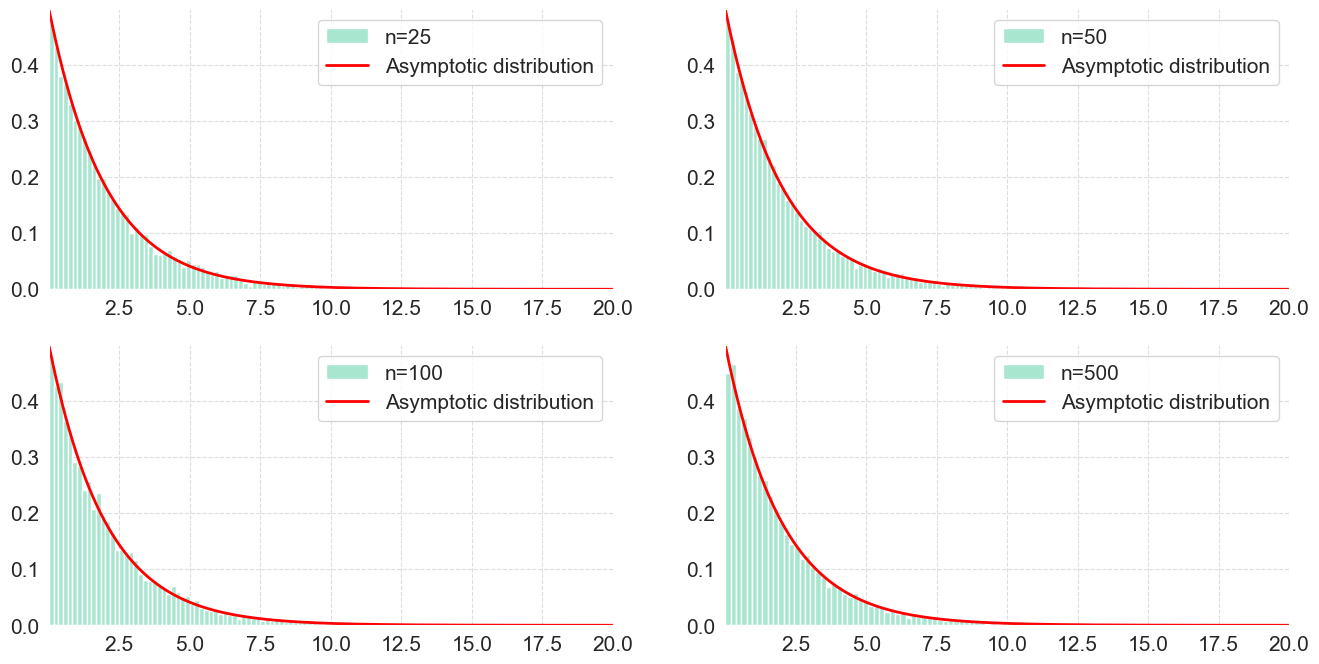

In [82]:
"""
Histogram and chi^2(2)
"""
x_values = np.linspace(0.001, 20, 1000)
chi_pdf_values = stats.chi2.pdf(x_values, 2)

fig, ax = plt.subplots(2, 2, figsize=(16, 8))
ax = ax.flatten()
for i in range(len(sample_sizes)):
    ax[i].hist(output_lr[:, i], bins=100, density=True, label="n={}".format(sample_sizes[i]), alpha=1.0);
    ax[i].plot(x_values, chi_pdf_values, color="red", label="Asymptotic distribution")
    ax[i].legend();


__Question 8__

The test seems to be well sized in the sense that the proportion of rejection the null hypothesis is close to the significance level.

In [83]:
np.sum(output_lr>stats.chi2.ppf(0.95, 2), axis=0) / num_sim

array([0.0538, 0.0528, 0.0492, 0.0496])

__Questio 9__

Naturally, the power is increasing with the sample size!

In [84]:
n = 500
num_sim = 10000
beta_true = 1.25
rho_true = 1.0
y_data_all = stats.gamma.rvs(a=rho_true, scale=1.0/beta_true, size=(num_sim, n))

In [85]:
sample_sizes = [25, 50, 100, 500]
output_power_lr = np.empty((num_sim, len(sample_sizes)))

for j, sample_size in enumerate(sample_sizes):
    for i in range(num_sim):

        # select data
        y_data = y_data_all[i, :sample_size]

        # estimate
        res = optimize.minimize(log_like_gamma, [1.0, 1.0], args=(y_data,),
                                bounds=((0.001, None), (0.001, None)))
        # calculate LR statistics
        output_power_lr[i, j] = 2 * (log_like_gamma([1.0, 1.0], y_data) - log_like_gamma(res.x, y_data))


In [86]:
np.sum(output_power_lr>stats.chi2.ppf(0.95, 2), axis=0) / num_sim

array([0.1501, 0.2532, 0.4741, 0.9973])

### Statsmodels implementation

In [87]:
from statsmodels.base.model import GenericLikelihoodModel

class GammaLogLModel(GenericLikelihoodModel):

    nparams = 2

    def loglike(self, params):

        endog = self.endog

        beta = params[0]
        rho = params[1]

        return stats.gamma.logpdf(endog, rho, scale = 1.0 / beta).sum()


res = GammaLogLModel(y_data).fit(start_params=[1.0, 1.0])

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.797829
         Iterations: 31
         Function evaluations: 61
                            GammaLogLModel Results                            
Dep. Variable:                      y   Log-Likelihood:                -398.91
Model:                 GammaLogLModel   AIC:                             805.8
Method:            Maximum Likelihood   BIC:                             822.7
Date:                Wed, 08 Oct 2025                                         
Time:                        20:35:49                                         
No. Observations:                 500                                         
Df Residuals:                     498                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

__Question 5__

In [88]:
res.t_test('par0=1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.3337      0.094      3.546      0.000       1.149       1.518

In [89]:
res.t_test('par1=1')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0923      0.061      1.505      0.132       0.972       1.212

## Problem 4: Shrinkage estimators

Assume that $\mathbf{X} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ is multivariate normal.

The [Mean-Squared-Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) of the sample mean can be written as

$$
\text{MSE} \equiv \text{E}[\| \bar{\mathbf{X}} - \boldsymbol{\mu} \|^2] = \text{E}\left[\| \bar{\mathbf{X}} - \text{E}[\bar{\mathbf{X}}] \|^2 \right] + \left \|\text{E}[\bar{\mathbf{X}}] - \boldsymbol{\mu}\right \|^2 = \text{Var}[\bar{\mathbf{X}}] + \text{Bias}[\bar{\mathbf{X}}, \boldsymbol{\mu}]^2
$$

where $\| \cdot \|$ denotes the [norm](https://en.wikipedia.org/wiki/Norm_(mathematics)). Basically, this tells us that we can look at an estimator in relation to its bias and inefficiency (variance).

In this exercise, we will see if we can find another estimator that performs better than the sample mean (in mean-square sense)

$$
\bar{\mathbf{X}} = \frac{1}{n} \sum_{i=1}^n \mathbf{X}_i
$$

__Question 1__

Assume that

$$
\boldsymbol{\mu} = \begin{bmatrix} 0.0 \\ 0.0 \\ 0.1 \\ -0.1 \\ 0.2 \end{bmatrix}
$$

and for $\theta \in (0, 1)$

$$
\boldsymbol{\Sigma} = \begin{bmatrix}
1 & \theta & \dots & \theta \\
\theta & 1 & \ddots & \vdots \\
\theta & \theta & \ddots & \theta \\
\theta & \theta & \dots & 1 \\
\end{bmatrix}
$$

We can think of $\theta$ as representing the overall correlation among the random variables.

For $\theta \in [0.0, 0.1, 0.2, ... , 0.9, 0.99]$ simulate 100 observations 10,000 times. Calculate the simulated value of the MSE for each different value of $\theta$ (remember that we know the true value of $\boldsymbol{\mu}$). Plot a stacked bar plot with MSE divided into variance and bias.


__Question 2__

[Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646) presents the [_James-Stein shrinkage estimator_](https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator) of the expected value

$$
\hat{\boldsymbol{\mu}} = (1-\alpha) \bar{\mathbf{X}} + \alpha \mathbf{b}
$$
where $\mathbf{b}$ is a constant vector. The optimal $\alpha$ is given by

$$
\alpha = \frac{1}{n} \frac{m \bar{\lambda} - 2 \lambda_1}{(\bar{\mathbf{X}} -  \mathbf{b})^\top (\bar{\mathbf{X}} -  \mathbf{b})}
$$
where  $m$ is the number of variables,  $\bar{\lambda}$ and $\lambda_1$ are respectively the average value and largest value of the eigenvalues of $\boldsymbol{\Sigma}$.

We choose to shrink towards the "grand-mean"

$$
\frac{\mathbf{1}^\top \bar{X}}{m} \mathbf{1}
$$

where $\mathbf{1}$ is a m-dimensional vector of ones.

Implement the estimator and perform the same calculations as in the previous question. Can the shrinkage estimator perform better than the sample mean?


### Solution

__Question 1__

In [90]:
num_var = 5
num_sim = 100000
num_obs = 100

theta_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
mu_values = np.array([0.0, 0.0, 0.1, -0.1, 0.2])

# standard normal random variables
random_draws = np.random.normal(size=(num_var, num_obs, num_sim))

all_mse = list()
all_bias = list()
all_var = list()
for theta in theta_values:

    # construct corr / covariance matrix
    corr = np.tile(theta, (num_var, num_var))
    np.fill_diagonal(corr, 1.0)

    # Use cholesky decomposition to normal random variables
    transformed_random_draws = mu_values[:, None, None] + np.einsum('ij,jlk->ilk',
                                                                    np.linalg.cholesky(corr), random_draws)

    # calculate average of all sample means
    expected_sample_mean = np.mean(np.mean(transformed_random_draws, axis=1), axis=1)

    # calculate the variance
    var =  np.mean(np.linalg.norm(np.mean(transformed_random_draws, axis=1) -
                          expected_sample_mean[:, None], axis=0)**2)

    # calculate the bias squared
    bias = np.linalg.norm(expected_sample_mean - mu_values)**2

    # calculate the total MSE (should be equal to var + bias)
    mse = np.mean(np.linalg.norm(np.mean(transformed_random_draws, axis=1) - mu_values[:, None], axis=0)**2)
    # or just use np.trace(corr) / num_obs <- theoretical correct value

    all_mse.append(mse)
    all_bias.append(bias)
    all_var.append(var)



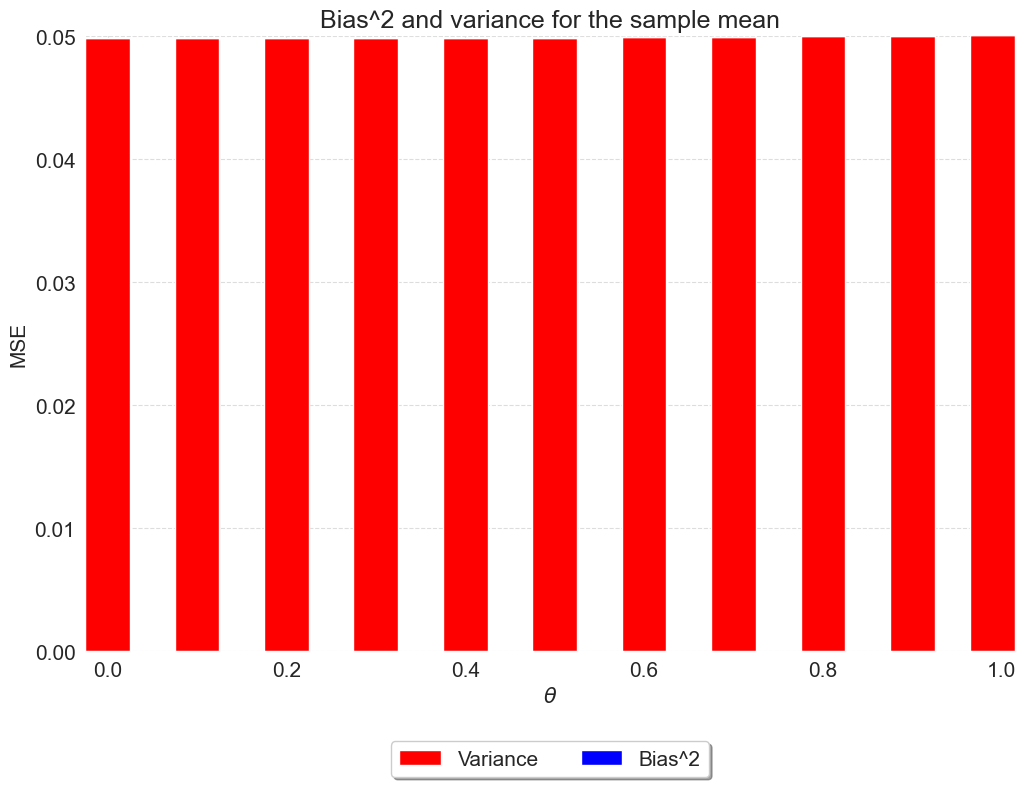

In [91]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(theta_values, all_var, width=0.05, label="Variance", color="red");
ax.bar(theta_values, all_bias, width=0.05, bottom=all_var, label="Bias^2", color="blue");
ax.set_ylabel('MSE')
ax.set_xlabel('$\\theta$')
ax.set_title("Bias^2 and variance for the sample mean")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=2);

The sample mean is an unbiased estimator so the only problem is coming from the variance.

__Question 2__


We see that with limited correlation between the variables, then the shrinkage estimator lowers the total MSE.

In [92]:
all_mse_shrink = list()
all_bias_shrink = list()
all_var_shrink = list()
for theta in theta_values:

    # construct corr / covariance matrix
    corr = np.tile(theta, (num_var, num_var))
    np.fill_diagonal(corr, 1.0)

    # Use cholesky decomposition to normal random variables
    transformed_random_draws = mu_values[:, None, None] + np.einsum('ij,jlk->ilk',
                                                                    np.linalg.cholesky(corr), random_draws)

    # average and maximum eigenvalue
    eig_vals = np.linalg.eigvals(corr)
    max_eig = max(eig_vals)
    avg_eig = np.mean(eig_vals)

    # get grand mean
    x_bar = np.mean(transformed_random_draws, axis=1)
    b = np.mean(x_bar, axis=0)
    b = np.tile(b, (num_var, 1))

    # calculate optimal alpha
    diff = x_bar - b
    denominator = np.einsum('ij,ij->j', diff, diff)

    alpha = (1.0 / num_obs) * (num_var * avg_eig - 2 * max_eig)  / denominator
    alpha = np.clip(alpha, 0, 1)
    alpha = np.tile(alpha, (num_var, 1))

    # shrinkage estimator
    mu_est = x_bar * (1 - alpha) + b * alpha

    # calculate average of all mean estimates
    expected_sample_mean = np.mean(mu_est, axis=1)

    # calculate the variance
    var =  np.mean(np.linalg.norm(mu_est - expected_sample_mean[:, None], axis=0)**2)

    # calculate bias squared
    bias = np.linalg.norm(expected_sample_mean - mu_values)**2

    # calculate the total MSE (should be equal to var + bias)
    mse = np.mean(np.linalg.norm(mu_est - mu_values[:, None], axis=0)**2)

    all_mse_shrink.append(mse)
    all_bias_shrink.append(bias)
    all_var_shrink.append(var)


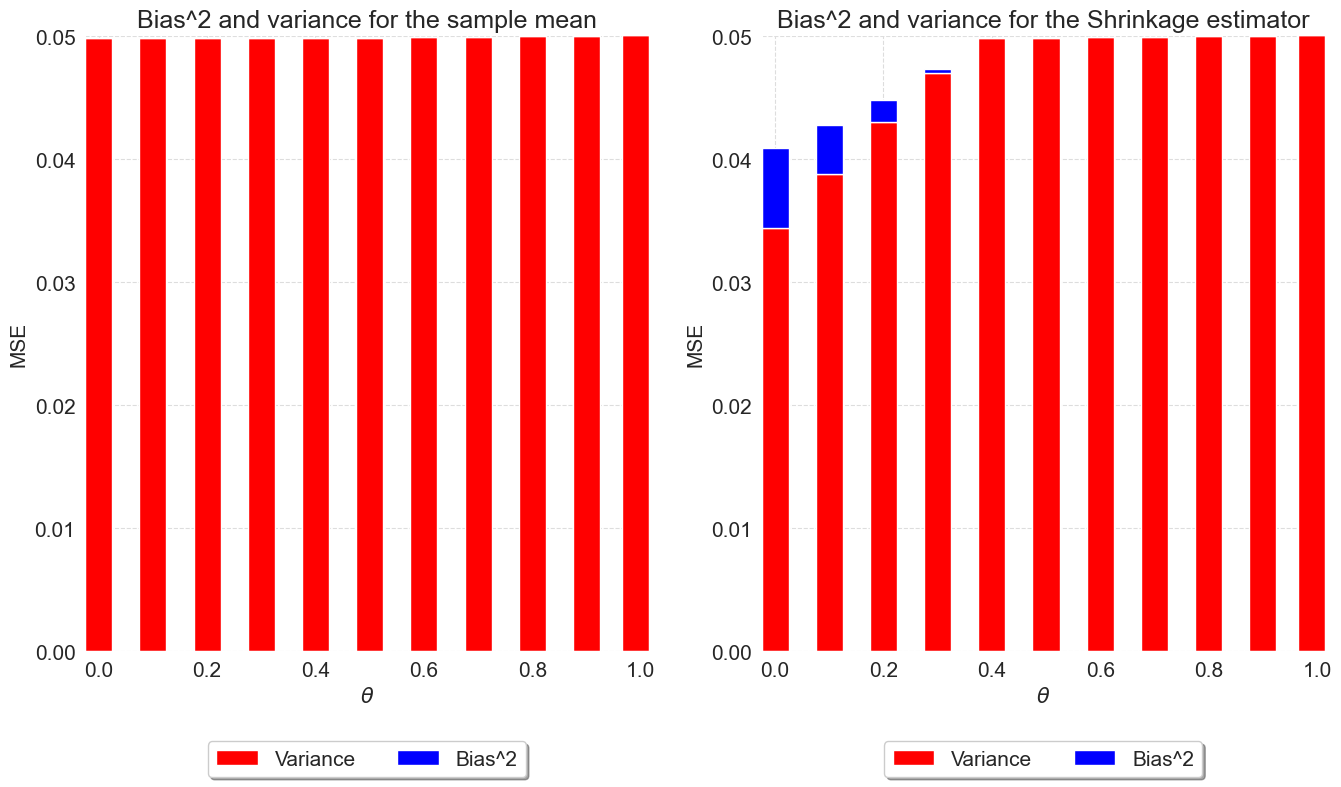

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))


ax[0].bar(theta_values, all_var, width=0.05, label="Variance", color="red");
ax[0].bar(theta_values, all_bias, width=0.05, bottom=all_var, label="Bias^2", color="blue");
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('$\\theta$')
ax[0].set_title("Bias^2 and variance for the sample mean")
ax[0].legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=2);

ax[1].bar(theta_values, all_var_shrink, width=0.05, label="Variance", color="red");
ax[1].bar(theta_values, all_bias_shrink, width=0.05, bottom=all_var_shrink, label="Bias^2", color="blue");
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('$\\theta$')
ax[1].set_title("Bias^2 and variance for the Shrinkage estimator")
ax[1].legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=2);

## Problem 5:  Ledoit and Wolf (2003) [Optional]

In the lectures, we talked about one shrinkage estimator, namely the one suggested by [Ledoit and Wolf (2004), "A well-conditioned estimator for large-dimensional covariance matrices"](https://www.sciencedirect.com/science/article/pii/S0047259X03000964).

In this problem, we will examine an alternative shrinkage estimator suggested by [Ledoit and Wolf (2003), Improved estimation of the covariance matrix
of stock returns with an application to
portfolio selection](https://www.sciencedirect.com/science/article/abs/pii/S0927539803000070).

Following the notation in the paper, the sample mean and sample covariance are given by

$$
\mathbf{m}_T = \frac{1}{T}\mathbf{X}\mathbf{1}
$$

and

$$
\mathbf{S}_T = \frac{1}{T}\mathbf{X} \left(\mathbf{I} - \frac{1}{T} \mathbf{1} \mathbf{1}^\top\right) \mathbf{X}^\top
$$

Ledoit and Wolf (2003) notes that since $\mathbf{rank}(\mathbf{AB}) \leq \mathbf{rank}(\mathbf{A})$ then $\mathbf{rank}(\mathbf{S}) \leq \mathbf{rank}\left(\mathbf{I} - \frac{1}{T} \mathbf{1} \mathbf{1}^\top\right) =  T-1$  why we need $N > T-1$ for a non rank-deficient covariance matrix.

In [94]:
"""
Check
"""
np.linalg.matrix_rank(np.eye(5) - np.outer(np.ones(5), np.ones(5)) / 5)

np.int64(4)

Ledoit and Wolf (2003) assume that stock returns follow a [single-index model](https://en.wikipedia.org/wiki/Single-index_model)

$$
x_{it} = \alpha_i + \beta_i x_{mt} + \varepsilon_{it}
$$

with $\text{Var}[\varepsilon_{it}] = \delta_{ii}$. The error terms are assumed uncorrelated.

The covariance matrix is then given by

$$
\mathbf{\Phi} = \sigma_m^2 \beta \beta^\top + \mathbf{\Delta}
$$

where $\mathbf{\Delta} = \text{diag}(\delta_{11}, ..., \delta_{NN})$. By estimating $\beta_i, i=1,...,N$ by running regressions and obtaining the OLS slope estimate $b_i$ and the residual variance $d_{ii}$, we can estimate the covariance matrix

$$
\mathbf{F} = s_m^2 \mathbf{b} \mathbf{b}^\top + \mathbf{D}
$$

where $\mathbf{D} = \text{diag}(d_{11}, ..., d_{NN})$ and $s_m^2$ is the sample variance of market returns.

Our problem is that $\mathbf{S}_T$ is unbiased (consistent), but not efficient while $\mathbf{F}$ is not unbiased/consistent, but has smaller variance.  The shrinkage estimator is assumed to take the form

$$
\mathbf{S}^*  = \alpha \mathbf{F} + (1 - \alpha) \mathbf{S}_T
$$

Thus, the shrinkage intensity will take the form  $\alpha = \kappa / T$ where $\kappa$ is a constant. We notice that the shrinkage vanish asymptotically. The optimal shrinkage constant is found by minimizing the frobenius norm

$$
\Vert \alpha \mathbf{F} + (1 - \alpha) \mathbf{S}_T - \boldsymbol{\Sigma} \Vert
$$

Ledoit and Wolf (2003) show that the optimal shrinkage constant is given by

$$
\kappa = \frac{\pi - \rho}{\gamma} = \frac{\sum_{i=1}^N\sum_{j=1}^N \pi_{ij} - \sum_{i=1}^N\sum_{j=1}^N \rho_{ij}}{\sum_{i=1}^N\sum_{j=1}^N \gamma_{ij}}
$$

where $\pi_{ij} = \text{AsyVar}[\sqrt{T}s_{ij}]$, $\rho_{ij} = \text{AsyCov}[\sqrt{T} f_{ij}, \sqrt{T} s_{ij}]$  and $\gamma_{ij} = (\phi_{ij} - \sigma_{ij})^2$.

However, these quantities depend on the true, unknown covariance matrix. Ledoit and Wolf (2003) show that a consistent estimator of $\pi_{ij}$  is given by

$$
p_{ij} = \frac{1}{T} \sum \left[(x_{it} - m_i)(x_{jt} - m_j) - s_{ij} \right]^2
$$

A consistent estimator of $\rho_{ij}$ is given by $p_{ij}$ for $i=j$ and for $i \neq j$ then we have $r_{ij} = 1/T \sum_{t=1}^T r_{ijt}$ with

$$
r_{ijt} = \frac{s_{j,m} s_m (x_{it} - m_i) + s_{i, m} s_m (x_{jt} - m_j) - s_{j,m} s_{i, m} (x_{mt} - m_{mkt})}{s_m^2} (x_{mt} - m_{mkt})(x_{it} - m_i)(x_{jt} - m_j) - f_{ij}s_{ij}
$$

A consistent estimator of $\gamma_{ij}$ is given by $c_{ij} = (f_{ij} - s_{ij})^2$.


__Question 1__

Define a function implementing the presented shrinkage estimator.

__Question 2__

We want to simulate data from the model

$$
r_{it} = \beta_i x_{mt} + \varepsilon_{it}
$$

when assuming $\beta_i \sim \mathcal{U}(-1, 1.5)$ (the $\beta$s follow a uniform distribution), $x_{mt} \sim N(0.05, 0.2^2)$ and $\varepsilon_{it} \sim N(0, 0.05^2)$.

Simulate data when $T=50, N=100$ and when $T=5000, N=5$. How does the shrinkage estimates compare to the sample covariance matrix in the two cases?

__Question 3__

We define the _percentage relative improvement in average loss_ of $\mathbf{S}^*$ as (we omit $_T$ for simplicity)

$$
\text{PRIAL}(\mathbf{S}^*) = \frac{\text{E}[\Vert \mathbf{S} - \boldsymbol{\Sigma} \Vert]^2 - \text{E}[\Vert \mathbf{S}^* - \boldsymbol{\Sigma} \Vert]^2}{\text{E}[\Vert \mathbf{S} - \boldsymbol{\Sigma} \Vert]^2}
$$

If PRIAL is positive, then the shrinkage estimator performs better than the sample covariance.

Create a simulation study that compares the PRIAL between the suggested shrinkage estimator and the sample covariance. Consider $T \in \{5, 10, 25, 50, 100, 500\}$ and maintain the assumptions from the previous question.

### Solution

__Question 1__

In [95]:
def ledoit_wolf_single_index(returns: np.ndarray, market_return: np.ndarray, demean: bool = True) -> Tuple[np.ndarray, float]:
    """
    Computes the Ledoit and Wolf (2003) shrinkage covariance estimator

    See https://www.sciencedirect.com/science/article/abs/pii/S0927539803000070

    Parameters
    ----------
    returns:
        Num. observations x Num. variables
    market_return:
        Market return, 1-D array
    demean:
        Boolean indicating whether to demean data.

    Returns
    -------
    np.ndarray
        Covariance matrix

    """

    # get dimensions
    T, N = np.shape(returns)

    # demean returns if necessary
    if demean:
        x = returns - np.mean(returns, axis=0)[None, :]
        x_mkt = market_return - np.mean(market_return)
    else:
        x = returns
        x_mkt = market_return

    # sample covariance matrix
    S = x.T @ x / T

    # shrinkage target
    var_mkt = x_mkt @ x_mkt / T
    cov_mkt = x_mkt @ x / T
    beta = cov_mkt / var_mkt
    F = np.outer(beta, beta) * var_mkt
    np.fill_diagonal(F, np.diag(S))

    # shrinkage intensity
    # estimate of pi
    x2 = x ** 2
    p = 1 / T * np.sum(x2.T @ x2) - np.sum(S ** 2)

    # estimate rho
    # diagonal elements
    r_diag = 1 / T * np.sum(x2 ** 2) - sum(np.diag(S) ** 2)

    # off diagonal elements
    z = x * x_mkt[:, None]
    v1 = x2.T @ z / T
    r_off_diag_1 = np.sum(v1 * cov_mkt[None, :]) / var_mkt - np.sum(np.diag(v1) * cov_mkt) / var_mkt

    v2 = z.T @ z / T
    r_off_diag_2 = np.sum(v2 * np.outer(cov_mkt,  cov_mkt)) / var_mkt**2 \
                   - np.sum(np.diag(v2) * cov_mkt**2) / var_mkt**2

    r_off_diag_3 = np.sum(F*S) - np.sum(np.diag(F*S))

    r_off_diag = 2 * r_off_diag_1 - r_off_diag_2 - r_off_diag_3

    r = r_diag + r_off_diag

    # estimate gamma
    c = np.linalg.norm(S - F, "fro") ** 2

    # compute shrinkage constant
    k = (p - r) / c
    alpha = max(0, min(1, k / T))

    # return shrinkage estimator1
    return alpha * F + (1 - alpha) * S, alpha

__Question 2__

In [96]:
T = 100
N = 50

mkt_return = np.random.normal(loc=0.05, scale=0.2, size=T)
betas = np.random.uniform(low=-1, high=1.5, size=N)
returns = mkt_return[:, None] * betas[None, :] + np.random.normal(loc=0, scale=0.05, size=(T, N))

In [97]:
np.cov(returns, rowvar=False)

array([[ 0.00275847, -0.00468671, -0.00518872, ...,  0.00040242,
        -0.00177081,  0.0023643 ],
       [-0.00468671,  0.05172163,  0.0576237 , ..., -0.00899496,
         0.01985867, -0.02301151],
       [-0.00518872,  0.0576237 ,  0.0704709 , ..., -0.01078972,
         0.0231154 , -0.0266295 ],
       ...,
       [ 0.00040242, -0.00899496, -0.01078972, ...,  0.00523584,
        -0.00385854,  0.00464191],
       [-0.00177081,  0.01985867,  0.0231154 , ..., -0.00385854,
         0.01008433, -0.00926674],
       [ 0.0023643 , -0.02301151, -0.0266295 , ...,  0.00464191,
        -0.00926674,  0.01321934]], shape=(50, 50))

In [98]:
ledoit_wolf_single_index(returns, mkt_return)

(array([[ 0.00273088, -0.00465798, -0.00548709, ...,  0.00089858,
         -0.00185724,  0.00216378],
        [-0.00465798,  0.05120442,  0.05722109, ..., -0.00937067,
          0.01936791, -0.02256452],
        [-0.00548709,  0.05722109,  0.06976619, ..., -0.01103864,
          0.02281537, -0.02658098],
        ...,
        [ 0.00089858, -0.00937067, -0.01103864, ...,  0.00518348,
         -0.0037363 ,  0.00435297],
        [-0.00185724,  0.01936791,  0.02281537, ..., -0.0037363 ,
          0.00998348, -0.008997  ],
        [ 0.00216378, -0.02256452, -0.02658098, ...,  0.00435297,
         -0.008997  ,  0.01308714]], shape=(50, 50)),
 1)

In [99]:
T = 5000
N = 5

mkt_return = np.random.normal(loc=0.05, scale=0.2, size=T)
betas = np.random.uniform(low=-1, high=1.5, size=N)
returns = mkt_return[:, None] * betas[None, :] + np.random.normal(loc=0, scale=0.05, size=(T, N))

In [100]:
returns.shape

(5000, 5)

In [101]:
np.cov(returns, rowvar=False)

array([[ 0.00259717,  0.00134691,  0.00112796, -0.00067235, -0.00029653],
       [ 0.00134691,  0.09023379,  0.07653595, -0.04207175, -0.01518344],
       [ 0.00112796,  0.07653595,  0.06931339, -0.03677093, -0.01312349],
       [-0.00067235, -0.04207175, -0.03677093,  0.02275176,  0.00720514],
       [-0.00029653, -0.01518344, -0.01312349,  0.00720514,  0.00512312]])

In [102]:
ledoit_wolf_single_index(returns, mkt_return)

(array([[ 0.00259665,  0.00134642,  0.00114918, -0.00066063, -0.00026752],
        [ 0.00134642,  0.09021574,  0.0765331 , -0.04208422, -0.01515724],
        [ 0.00114918,  0.0765331 ,  0.06929953, -0.03676392, -0.01316044],
        [-0.00066063, -0.04208422, -0.03676392,  0.02274721,  0.00723186],
        [-0.00026752, -0.01515724, -0.01316044,  0.00723186,  0.0051221 ]]),
 np.float64(0.4510508528211838))

__Question 3__

In [103]:
N = 10
T = 55
num_sim = 10000

# set random seed
np.random.seed(0)

# true covariance matrix
sigma_i = 0.01
sigma_m = 0.2
betas = np.random.uniform(low=-1, high=1.5, size=N)
cov_true = np.outer(betas, betas)*sigma_m**2 + np.eye(N) * sigma_i**2

sample_sizes = [5, 10, 25, 50, 100, 500]

prial = list()

for T in sample_sizes:
    loss_sample = list()
    loss_shrinkage = list()
    for i in range(num_sim):

        mkt_returns = np.random.normal(loc=0.05, scale=sigma_m, size=T)
        returns = mkt_returns[:, None] * betas[None, :] + np.random.normal(loc=0,
                                                                           scale=sigma_i,
                                                                           size=(T, N))

        mkt_return_test = np.average(returns, axis=1)

        sample_cov_mat = np.cov(returns, rowvar=False)
        shrink_cov_mat = ledoit_wolf_single_index(returns, mkt_return_test)[0]

        loss_sample.append(np.linalg.norm(sample_cov_mat - cov_true))
        loss_shrinkage.append(np.linalg.norm(shrink_cov_mat - cov_true))

    prial_temp =  ((np.mean(loss_sample)**2 / N) - (np.mean(loss_shrinkage)**2 / N)) / (np.mean(loss_sample)**2 / N)
    prial.append(prial_temp)

    print("T={}".format(T))
    print("PRIAL: {:.2f}%".format(prial_temp * 100))
    print("\n")

T=5
PRIAL: 15.01%


T=10
PRIAL: 8.13%


T=25
PRIAL: 3.04%


T=50
PRIAL: 1.64%


T=100
PRIAL: 0.70%


T=500
PRIAL: 0.09%




## Problem 6: Simulating the gains of denoising the correlation / covariance matrix

__Note:__ This problem is heavily inspired [Marcos M. Lopéz de Prado (2020), "Machine Learning for Asset Managers"](https://www.amazon.com/Machine-Learning-Managers-Elements-Quantitative/dp/1108792898)

At the lectures, we discussed how we can use random matrix theory to denoise the correlation matrix. In this problem, we will see the potential benefits  of this approach.

__Question 1__

In order to perform a relevant simulation study, we need to define a method for defining the true correlation structure that we will use to simulate e.g. returns.

The following code can generate a random true covariance matrix and mean vector.

In [104]:
def form_block_corr_matrix(num_blocks: int, block_size: int, block_corr: float) -> np.ndarray:

    """
    Create a block correlation matrix with a number of equal size blocks.
    Each block have the same inter block correlation.

    Parameters
    ----------
    num_blocks:
        Number of blocks
    block_size:
        Block size.
    block_corr
        Inter block correlation.

    Returns
    -------
    np.ndarray
        Correlation matrix.

    """

    block = np.ones((block_size, block_size)) * block_corr
    np.fill_diagonal(block, 1.0)

    corr_mat = block_diag(*([block] * num_blocks))

    return corr_mat

def form_true_cov_and_mean(num_blocks: int, block_size: int, block_corr: float) -> Tuple[np.ndarray, np.ndarray]:

    """
    Creates a covariance matrix and mean vector

    Parameters
    ----------
    num_blocks:
        Number of blocks
    block_size:
        Block size.
    block_corr
        Inter block correlation.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Covariance matrix, mean vector
    """

    # generate corr mat
    corr_mat = form_block_corr_matrix(num_blocks, block_size, block_corr)
    num_assets = corr_mat.shape[0]

    idx = np.arange(num_assets)
    np.random.shuffle(idx)
    idx_selector = np.tile(idx.reshape(num_assets, 1), num_assets)

    corr_mat = corr_mat[idx_selector, idx_selector.T]

    # generate vols
    vols =  np.random.uniform(0.05, 0.2, num_assets)

    # generate cov mat
    cov_mat = corr_to_cov_matrix(corr_mat, vols)

    # generate means (all assets have same sharpe ratio)
    mu = np.random.normal(vols, vols, size=num_assets)

    return mu, cov_mat

Simulate a the true covariance matrix when we have two blocks with five assets. Assume that the block correlation is 0.5. Plot the correlation matrix.

__Question 2__

Simulate 50 observations from the data generating process specified above (draw 50 observation from a multivariate normal with mean vector and covariance matrix equal to the ones "simulated" above).

Calculate the sample covariance and correlation matrix.

Plot the empirical correlation matrix.

__Quesition 3__

We have at the lectures looked at how we can denoise the correlation matrix. We seek to specificy a method to denoise the covariance matrix. Below, we have defined a function to denoise the covariance matrix.

In [105]:
def denoise_cov_mat(cov_mat: np.ndarray, ratio:float, bandwidth:float=0.01, x_eval=None)->np.ndarray:

    """
    Denoises covariance matrix

    Parameters
    ----------

    cov_mat:
        Covariance matrix.
    ratio:
        Ratio between num. variables and num. obs.
    bandwidth:
        Bandwidth for kernel density.
    x_eval:
        Values for which to evaluate the pdf.

    Returns
    -------
    np.ndarray
        Denoised covariance matrix.

    """

    if x_eval is None:
        x_eval = np.linspace(0.0, 5.0, 10000)

    # get corr mat
    corr_mat = cov_to_corr_matrix(cov_mat)

    # get eig vals and eig vectors
    eig_vals, eig_vectors = np.linalg.eigh(corr_mat)

    # estimate largest random eigenvalue
    res = optimize.minimize(fitting_error, 0.25, args=(ratio, x_eval, eig_vals),
                            bounds=((1e-5, 1 - 1e-5),))

    var = res.x[0]
    lambda_max = marchencko_pastur_bounds(var, ratio)[-1]

    # number of recovered true factors
    num_factors = np.sum(eig_vals > lambda_max)

    # make sure that eigenvalues and eigenvectors are sorted
    indices = eig_vals.argsort()[::-1]
    eig_vals_sorted = eig_vals[indices]
    eig_vectors_sorted = eig_vectors[:, indices]

    # get denoised corr mat
    denoised_corr = crem_denoised_corr_mat(eig_vals_sorted, eig_vectors_sorted, num_factors)

    # new cov mat
    new_cov_mat = corr_to_cov_matrix(denoised_corr, np.diag(cov_mat) ** 0.5)

    return new_cov_mat

Denoise the previously estimated covariance matrix. Plot the denoised correlation matrix.

__Question 4__

Define a function returning the minimum variance or the maximum Sharpe ratio portfolio given the covariance matrix and in the latter case also the mean vector.

__Question 5__

We are now ready to perform a simulation study:

1. Generate a covariance matrix and mean vector when we assume that we have 10 blocks of size 50 with correlation 0.5.
2. Generate 1000 observations from this model 1000 times. Estimate for each iteration the optimal weights (just minimum variance).
3. Compare the RMSE when using respectively the sample covariance and the denoised covariance (compare with the true minimum variance weights).

Note that the [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) is given by

$$
\text{RMSE} = \sqrt{\text{E}[(\hat{\theta}- \theta])^2}
$$

What approach yields the smallest RMSE?

### Solution

__Question 1__

We see what we expected. We have constructed a correlation matrix where each asset is correlated with four other assets.

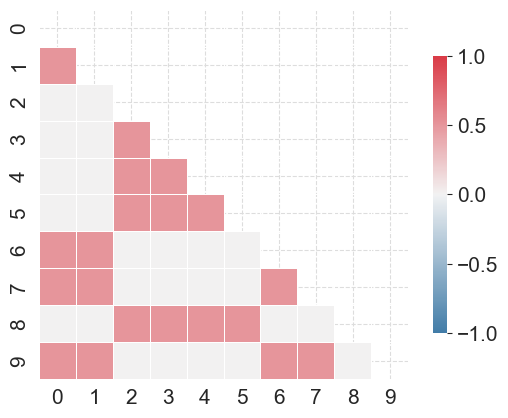

In [106]:
mu_true, cov_mat_true = form_true_cov_and_mean(2, 5, 0.5)
corr_mat_true = cov_to_corr_matrix(cov_mat_true)

correlation_plot(corr_mat_true)

__Question 2__

We see the same structure, but also some randomness!

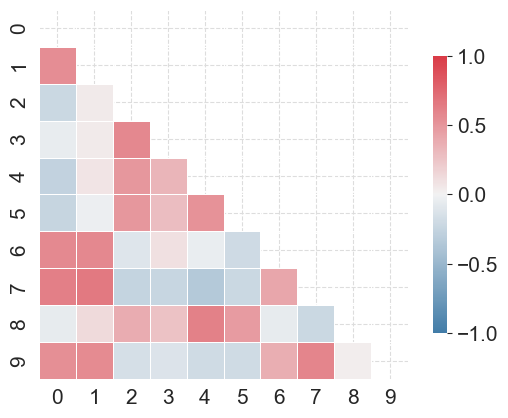

In [107]:
sim_data = np.random.multivariate_normal(mu_true, cov_mat_true, size=50)
cov_mat_est = np.cov(sim_data, rowvar=False)
corr_mat_est = cov_to_corr_matrix(cov_mat_est)

correlation_plot(corr_mat_est)

__Question 3__

In [108]:
cov_mat_denoised = denoise_cov_mat(cov_mat_est, 10 / 50)

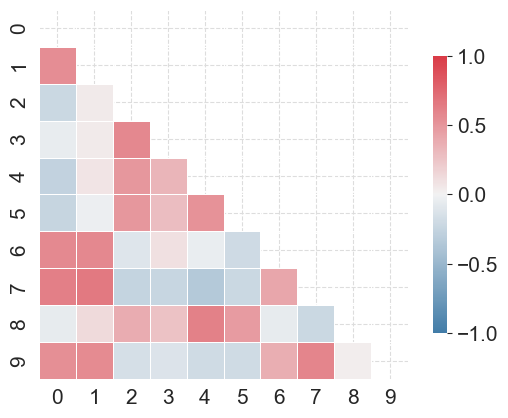

In [109]:
cov_mat_denoised
corr_mat_denoised = cov_to_corr_matrix(cov_mat_denoised)

correlation_plot(corr_mat_est)

__Question 4__

The minimum-variance portfolio is given by

$$
\begin{align}
\mathbf{w}_{\text{Min-Var}} = \frac{\boldsymbol{\Sigma}^{-1} \mathbf{1}}{\mathbf{1}^\top \boldsymbol{\Sigma}^{-1} \mathbf{1}}
\end{align}
$$

and the tangency portfolio (max Sharpe) is given by

$$
\mathbf{w}_{\text{Max-Sharpe}} = \frac{\boldsymbol{\Sigma}^{-1}(\boldsymbol{\mu} - r_f \mathbf{1})}{\mathbf{1}^\top \boldsymbol{\Sigma}^{-1}(\boldsymbol{\mu} - r_f \mathbf{1})}
$$

In [110]:
def optimal_portfolio_weights(cov_mat: np.ndarray, mu: np.ndarray=None):

    """
    Calculates either the minimum-variance or tangency portfolio.

    Parameters
    ----------
    cov_mat:
        Covariance matrix of returns
    mu:
        Expected excess returns.

    Returns
    -------
    np.ndarray
        Optimal portfolio weights.

    """

    inv_cov_mat = np.linalg.inv(cov_mat)
    one_vec = np.ones(cov_mat.shape[0])

    if mu is None:
        mu = one_vec

    opt_w = inv_cov_mat @ mu
    opt_w /= one_vec @ opt_w

    return opt_w

__Question 5__

In [111]:
mu_true, cov_mat_true = form_true_cov_and_mean(10, 50, 0.5)
corr_mat_true = cov_to_corr_matrix(cov_mat_true)

true_min_var_weights = optimal_portfolio_weights(cov_mat_true, mu=None)

num_sim = 500
num_obs = 1000

np.random.seed(0)
opt_weights_s = []
opt_weights_d = []

for i in range(num_sim):
    print(i)

    sim_data = np.random.multivariate_normal(mu_true, cov_mat_true, size=num_obs)
    cov_mat_est = np.cov(sim_data, rowvar=False)
    corr_mat_est = cov_to_corr_matrix(cov_mat_est)
    mu_est = np.mean(sim_data, axis=0)

    cov_mat_denoised = denoise_cov_mat(cov_mat_est, ratio = cov_mat_est.shape[0] / num_obs)

    opt_weights_d.append(optimal_portfolio_weights(cov_mat_denoised, mu=None))
    opt_weights_s.append(optimal_portfolio_weights(cov_mat_est, mu=None))

opt_weights_d = np.array(opt_weights_d)
opt_weights_s = np.array(opt_weights_s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [112]:
"""
RMSE
"""

rmse_s = np.sqrt(np.mean((opt_weights_s - true_min_var_weights)**2))
print(rmse_s)

rmse_d = np.sqrt(np.mean((opt_weights_d - true_min_var_weights)**2))
print(rmse_d)

0.004895590186704246
0.0011211278450043455


Clearly, the denoised covariance matrix results in the lowest RMSE!

## Problem 7: The distribution of the covariance matrix with normally distributed variables

Assume that $X_i \sim N(\mu, \sigma^2)$  and consider a random sample of size $T$. Define the sample mean

$$
\bar{X} = \frac{1}{T} \sum_{i=1}^T X_i
$$

and the sample variance

$$
S^2 = \frac{1}{T-1} \sum_{i=1}^T (X_i - \bar{X})^2
$$

We know that

$$
\bar{X} \sim N(\mu, \sigma^2 / T)
$$

It is possible to show that using the known $\mu$

$$
\frac{\sum_{i=1}^T (X_i - \mu)^2}{\sigma^2} \sim \chi^2 (T)
$$

and when losing one degree of freedom from estimating the mean

$$
\frac{\sum_{i=1}^T (X_i - \bar{X})^2}{\sigma^2} = \frac{(T-1)S^2}{\sigma^2}  \sim \chi^2 (T - 1)
$$

__Question 1__

Assume $\sigma = 0.2$, $\mu = 0$ and $T=10$. Perform a simulation study to check if the distributional assumptions are correct.

__Question 2__

We could rewrite the above expression such that

$$
S^2 \sim \frac{\sigma^2}{T-1} C
$$

where $C \sim \chi^2 (T - 1)$. It follows directly that

$$
\text{E}[S^2] = \frac{\sigma^2}{T-1} (T-1) = \sigma^2
$$

and

$$
\text{Var}[S^2] = \frac{\sigma^4}{(T-1)^2} 2 (T-1) = \frac{2 \sigma^4}{(T-1)}
$$

What happens when we increase $T$?

__Question 3__

The above can be generalized to the multivariate normal case. If we assume that $\mathbf{X}_i \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ follows a multivariate normal then

$$
T \mathbf{S}_T = \mathbf{Y}^\top \mathbf{Y} \sim W(\boldsymbol{\Sigma}, T)
$$

where $\mathbf{Y}$ is a matrix with demeaned data using the true $\boldsymbol{\mu}$ and $W(\boldsymbol{\Sigma}, T)$ denotes a [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution) with $T$ degrees of freedom. If we use the sample mean to demean, we would have


$$
T \mathbf{S}_T = \mathbf{Y}^\top \mathbf{Y} \sim W(\boldsymbol{\Sigma}, T-1)
$$

Assume

$$
\mathbf{X}_i \sim N(\mathbf{0}, \boldsymbol{\Sigma})
$$

with $T = 25$ and

$$
\boldsymbol{\Sigma} =
\begin{bmatrix}
1.0 & 0.9 &  0.7 \\
0.9 & 1.0 & 0.4 \\
0.7 & 0.4 & 1.0 \end{bmatrix}
$$

Simulate 10000 realizations of sample the covariance matrix and plot the histogram of $\rho_{1,2}$ (sample correlation between the first and second variable).


__Question 4__

Consider the same covariance matrix as in problem 1. Simulate the distribution of the minimum-variance weights.

### Solution

__Question 1__

In [131]:
mu = 0.0
sigma = 0.2
num_obs = 10
num_sim = 10000

x_sim = np.random.normal(loc=mu, scale=sigma, size=(num_sim, num_obs))

In [132]:
mu_est = np.mean(x_sim, axis=1)

x_demean_true = x_sim - mu
x_demean_sample = x_sim - mu_est[:, None]

test_stat_true = np.sum(x_demean_true**2 / sigma**2, axis=1)
test_stat_sample = np.sum(x_demean_sample**2 / sigma**2, axis=1)

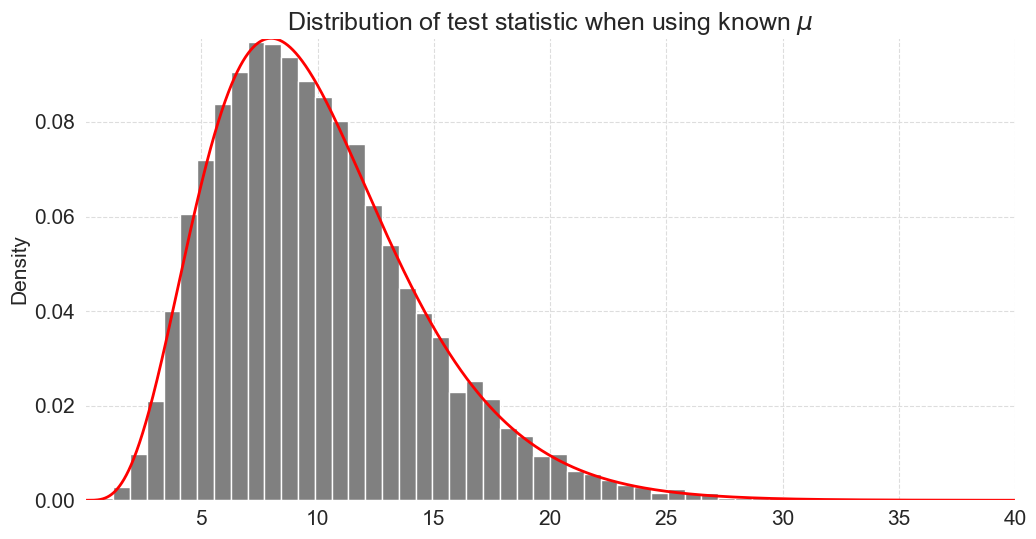

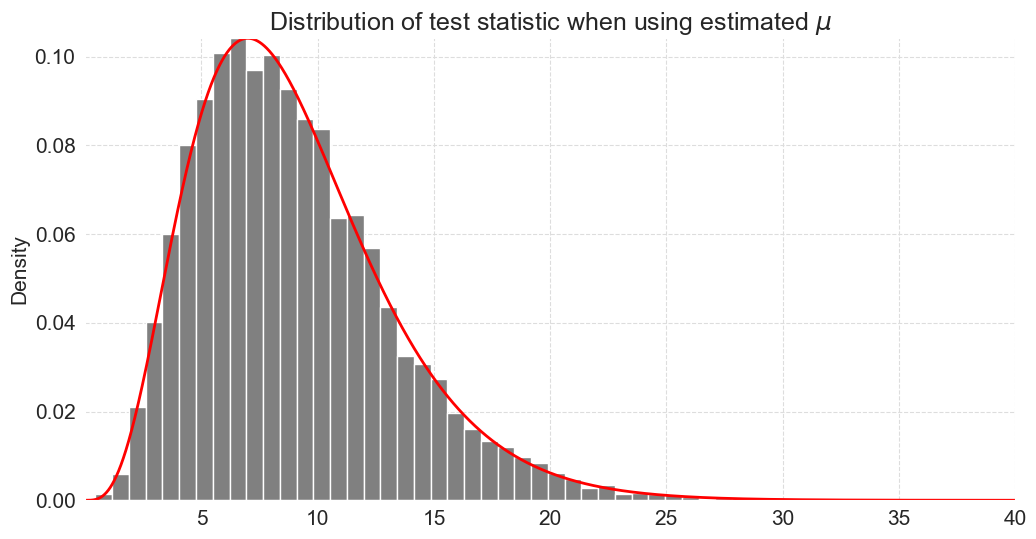

In [133]:
"""
True mu
"""
values = np.linspace(0.0001, 40, 10000)
pdf_values = stats.chi2.pdf(values, num_obs)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(values, pdf_values, label="True density, dof=10", color="red")
ax.hist(test_stat_true, bins=50,  density=True, color="gray");
ax.set_ylabel("Density");
ax.set_title("Distribution of test statistic when using known $\\mu$")

"""
sample mean
"""
values = np.linspace(0.0001, 40, 10000)
pdf_values = stats.chi2.pdf(values, num_obs - 1)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(values, pdf_values, label="True density, dof=9", color="red")
ax.hist(test_stat_sample, bins=50,  density=True, color="gray");
ax.set_ylabel("Density");
ax.set_title("Distribution of test statistic when using estimated $\\mu$");

__Question 2__

We see that the distribution collapses around the true value.

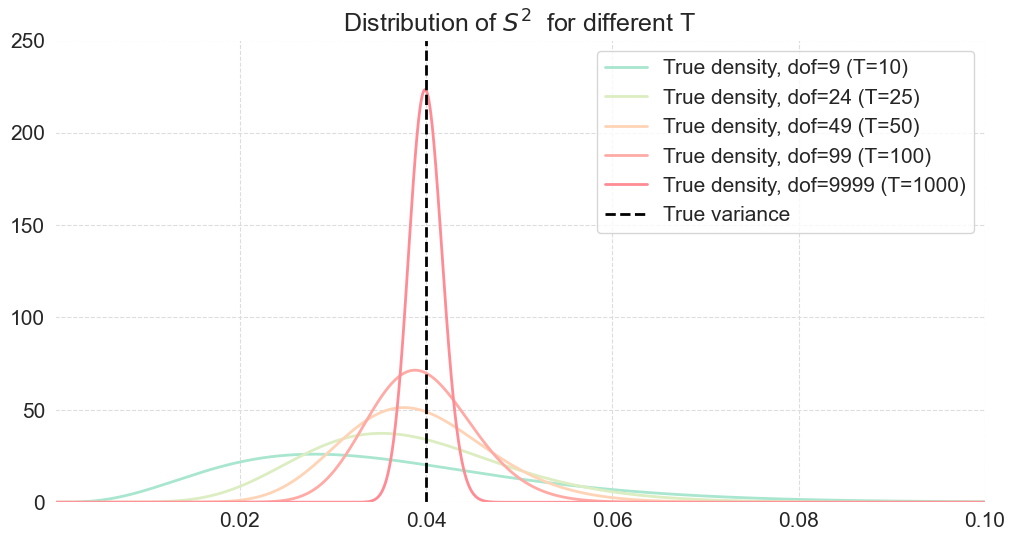

In [116]:
values = np.linspace(0.0001, 0.1, 10000)
pdf_values_10 = stats.chi2.pdf(values, 10 - 1, scale=(sigma**2 /10))
pdf_values_25 = stats.chi2.pdf(values, 25 - 1, scale=(sigma**2 /25))
pdf_values_50 = stats.chi2.pdf(values, 50 - 1, scale=(sigma**2 /50))
pdf_values_100 = stats.chi2.pdf(values, 100 - 1, scale=(sigma**2 /100))
pdf_values_1000 = stats.chi2.pdf(values, 1000 - 1, scale=(sigma**2 /1000))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(values, pdf_values_10, label="True density, dof=9 (T=10)")
ax.plot(values, pdf_values_25, label="True density, dof=24 (T=25)")
ax.plot(values, pdf_values_50, label="True density, dof=49 (T=50)")
ax.plot(values, pdf_values_100, label="True density, dof=99 (T=100)")
ax.plot(values, pdf_values_1000, label="True density, dof=9999 (T=1000)")
ax.plot([sigma**2, sigma**2], [0.0, 250.0], label="True variance", color="black", linestyle="--")
ax.set_title("Distribution of $S^2$  for different T");
ax.legend();

__Question 3__

In [117]:
T = 25

C = np.array([[1.0, 0.9, 0.7],
              [0.9, 1.0, 0.4],
              [0.7, 0.4, 1.0]])

num_sim = 90000

sim_cov_mat = stats.wishart.rvs(df = T-1, scale = C / T, size=num_sim)
sim_corr_mat = np.array([cov_to_corr_matrix(sim_cov_mat[i]) for i in range(num_sim)])

Text(0, 0.5, 'Density')

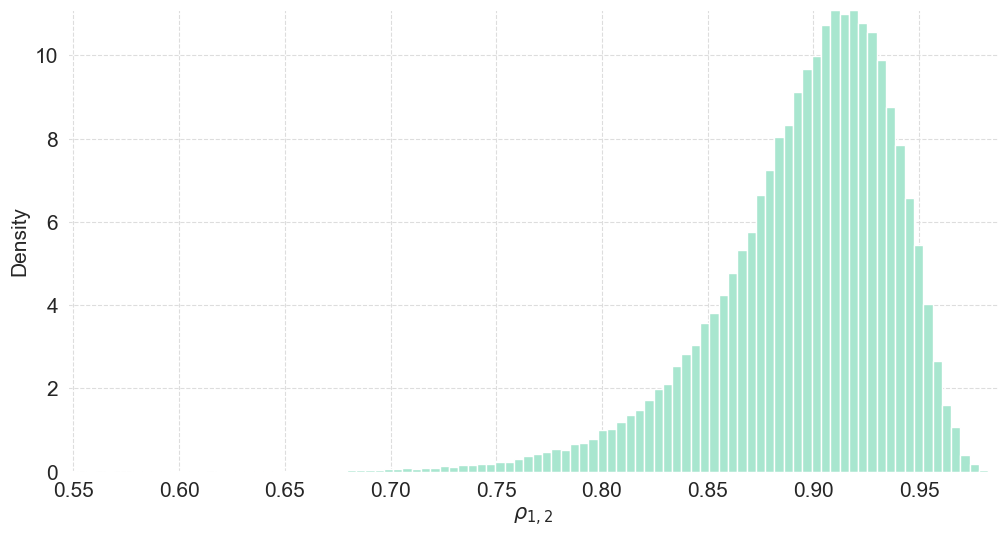

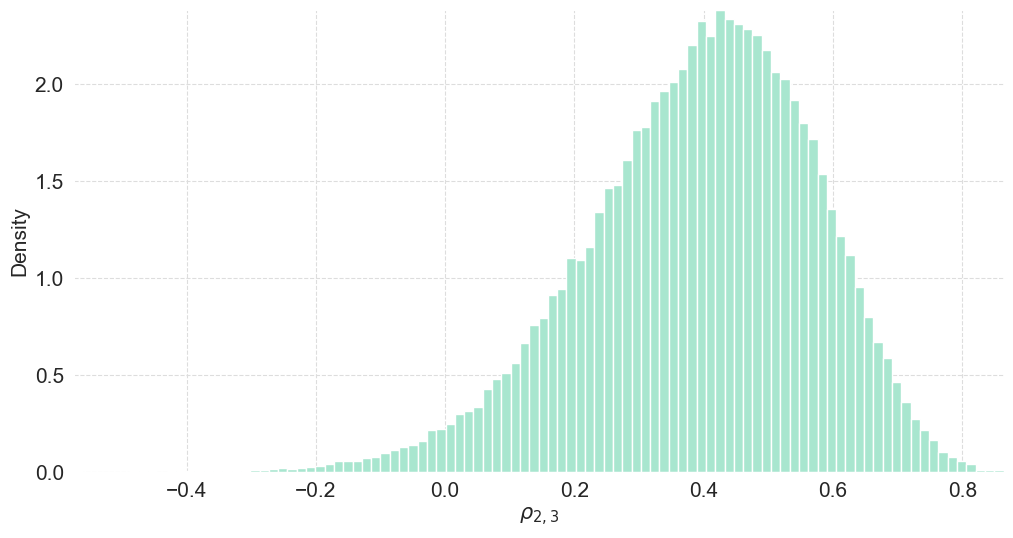

In [118]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_corr_mat[:, 0, 1], density=True, bins=100);
ax.set_xlabel("$\\rho_{1, 2}$")
ax.set_ylabel("Density")

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_corr_mat[:, 1, 2], density=True, bins=100);
ax.set_xlabel("$\\rho_{2, 3}$");
ax.set_ylabel("Density")

__Question 4__

In [119]:
# sample lenght
T = 25

# correlations
corr_mat = np.array([[1.0, -0.1, -0.2],
                     [-0.1, 1.0, 0.7],
                     [-0.2, 0.7, 1.0]])
# volatilities
vols = np.array([0.1, 0.1, 0.2])

# calculate covariance matrix
cov_mat = corr_to_cov_matrix(corr_mat, vols)

# sim covariances
num_sim = 90000
sim_cov_mat = stats.wishart.rvs(df=T-1, scale=cov_mat / T, size=num_sim)

In [120]:
sim_opt_weights = np.array([optimal_portfolio_weights(sim_cov_mat[i]) for i in range(num_sim)])

In [121]:
w_opt = optimal_portfolio_weights(cov_mat)

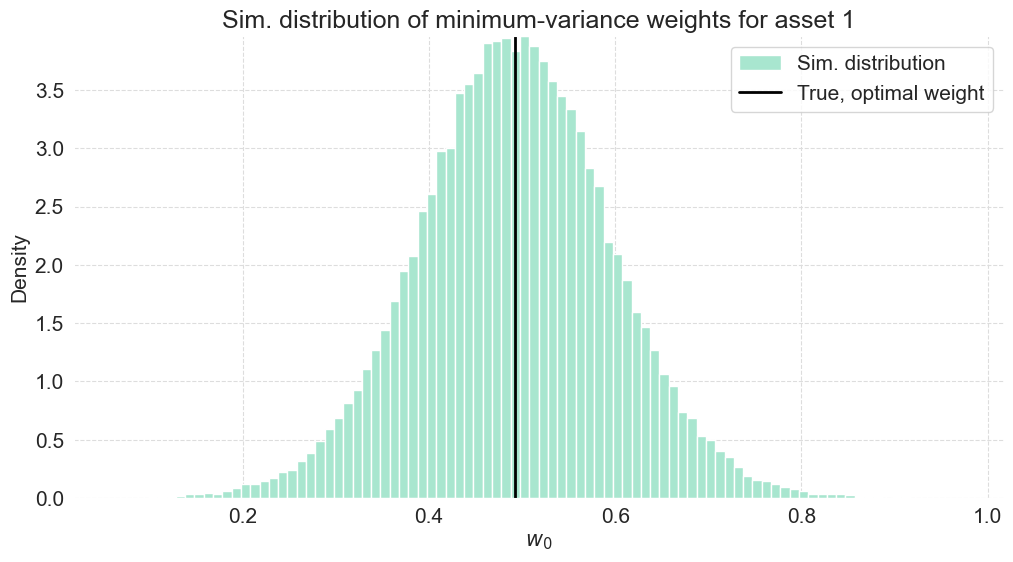

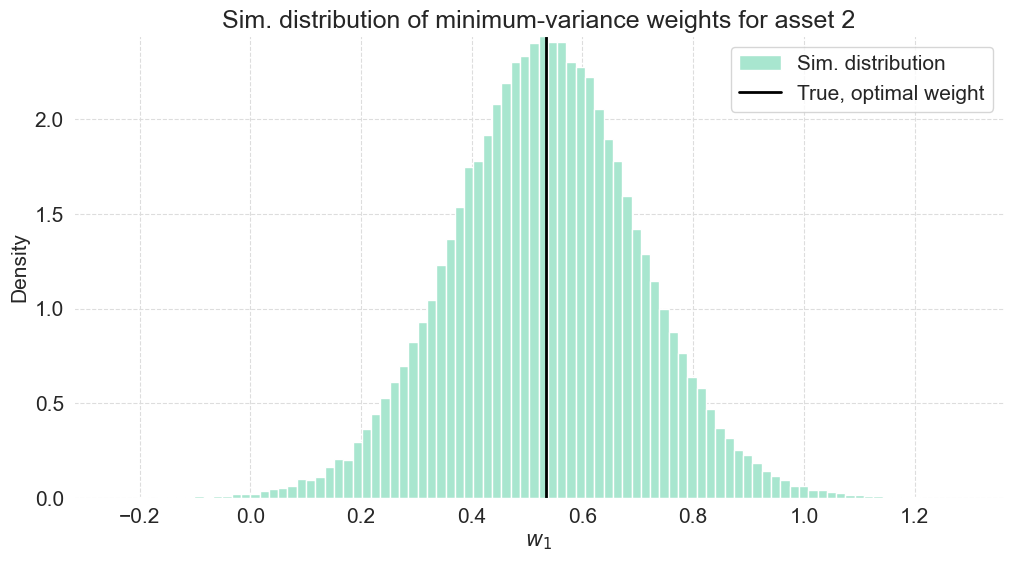

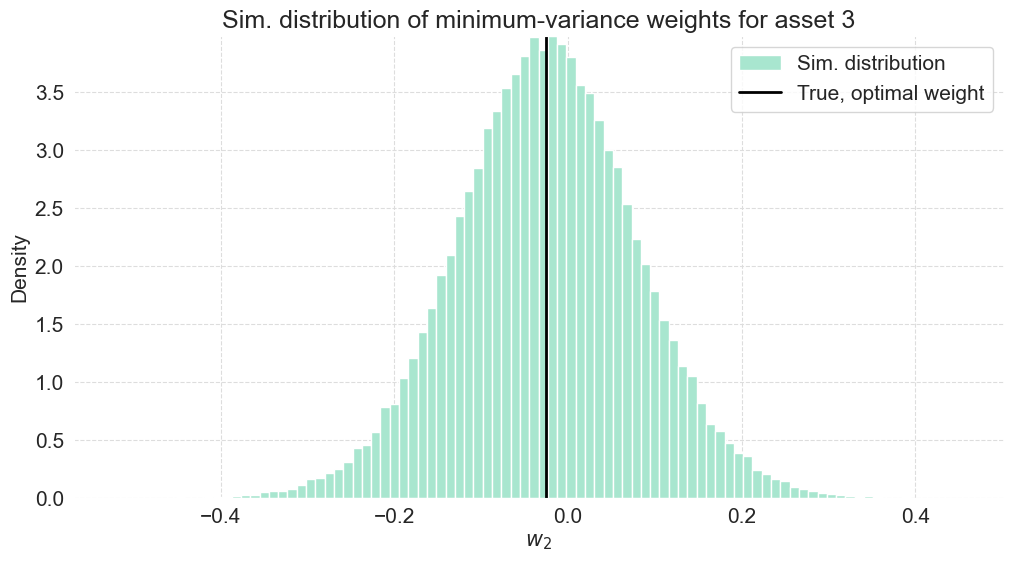

In [122]:
for i in range(len(w_opt)):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(sim_opt_weights[:, i], density=True, bins=100, label="Sim. distribution");
    ax.set_xlabel("$w_{}$".format(i))
    ax.axvline(w_opt[i], 0, 1, color="black", label="True, optimal weight")
    ax.set_ylabel("Density")
    ax.set_title('Sim. distribution of minimum-variance weights for asset {}'.format(i + 1))
    ax.legend();

## Problem 8: Time-varying correlation

We have so far assumed that data was identically and independent distributed when estimating covariance matrices and defining shrinkage estimators. However, in financial markets returns may be uncorrelated but we often find dependence in higher order moments. E.g. financial returns often exhibit volatility clustering.

__Question 1__

Get adjusted stock prices for Facebook (META), Amazon (AMZN), Apple (AAPL), Netflix (NFLX), and Alphabet (GOOG) from 2014. Calculate daily log returns.

__Question 2__

We want to specify an exponential filter to estimate the covariance matrix. To that end, we define ($\mathbf{x}_t$ is the return vector at time $t$)

$$
\boldsymbol{\mu}^{\lambda}_{T+1} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t
$$

and

$$
\boldsymbol{\Sigma}^{\lambda}_{T+1} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t \mathbf{x}_t^\top  - \boldsymbol{\mu}^{\lambda}_{T+1} (\boldsymbol{\mu}^{\lambda}_{T+1})^\top
$$

where $\gamma = 1 /  \sum_{t=1}^T e^{-\lambda (T-t)}$ to make the weights sum to one. $\lambda$ controls the decay of the exponential filter. A $\lambda=0.0055$ will represent a half-life of approximately six months with daily data.

Implement the exponential filter and apply it with $\lambda=0.0055$ on the downloaded data set.

__Question 3__

Plot the variance of Facebook.

Plot the correlation between Facebook and all the other stocks over the time period.

### Solution

__Quesition 1__

C:\Users\johan\AppData\Local\Temp\ipykernel_13024\3290409494.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  faang =yf.download(tickers, start=datetime.date(2014, 1, 1))
[*********************100%***********************]  5 of 5 completed


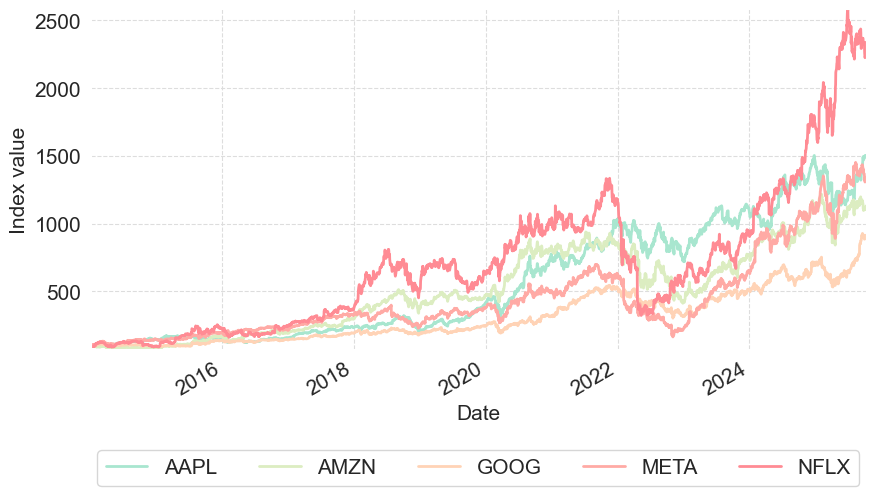

In [124]:
import yfinance as yf # yfiance can also directly be used to get data

"""
Get adjusted stock prices for Facebook (META), Amazon (AMZN), Apple (AAPL),
Netflix (NFLX), and Alphabet (GOOG).
"""
tickers = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
faang =yf.download(tickers, start=datetime.date(2014, 1, 1))

"""
Get adjusted close and normalize
"""
faang_adj_close = faang['Close']
faang_adj_close = faang_adj_close / faang_adj_close.iloc[0, :] * 100

"""
Plot stock prices
"""

ax = faang_adj_close.plot(figsize=(10, 5));
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.35), ncol=5);
ax.set_ylabel('Index value');

In [125]:
faang_adj_log_ret = np.log(faang_adj_close / faang_adj_close.shift(1)).dropna()

In [126]:
faang_adj_log_ret.tail()

Ticker,AAPL,AMZN,GOOG,META,NFLX
Date,,,,,
2025-10-02,0.006555,0.008035,0.003618,0.013445,-0.007174
2025-10-03,0.003455,-0.013125,0.000081,-0.022942,-0.007954
2025-10-06,-0.005168,0.006312,0.020324,0.007152,0.008625
2025-10-07,-0.000818,0.003976,-0.017568,-0.003612,0.023574
2025-10-08,0.005781,0.013347,-0.006536,0.008080,0.017593


__Question 2__

In [128]:
data = faang_adj_log_ret.values

def covariance_exponential_filter(data, decay=0.0055, zero_mean=False):

    data_out = np.einsum('ji,jk->jik', data, data)
    T = len(data)
    cov_matrices = list()
    mu_est = np.zeros_like(data.shape[1])

    for t in np.arange(1, T+1):

        tp = np.arange(0, t)
        weights = np.flip(np.exp(-decay * tp))
        sum_weights = np.sum(weights)

        if not zero_mean:
            mu_est = np.sum(data[:t, :] * weights[:, None], axis=0) / sum_weights

        cov_est =   np.sum(data_out[:t, :, :] * weights[:, None, None] / sum_weights, axis=0) - np.outer(mu_est, mu_est)

        cov_matrices.append(cov_est)

    cov_matrices = np.array(cov_matrices)

    return cov_matrices


cov_matrices = covariance_exponential_filter(data, decay=0.0055, zero_mean=True)
corr_matrices = np.array([cov_to_corr_matrix(cov_matrices[i]) for i in range(1, len(cov_matrices))])

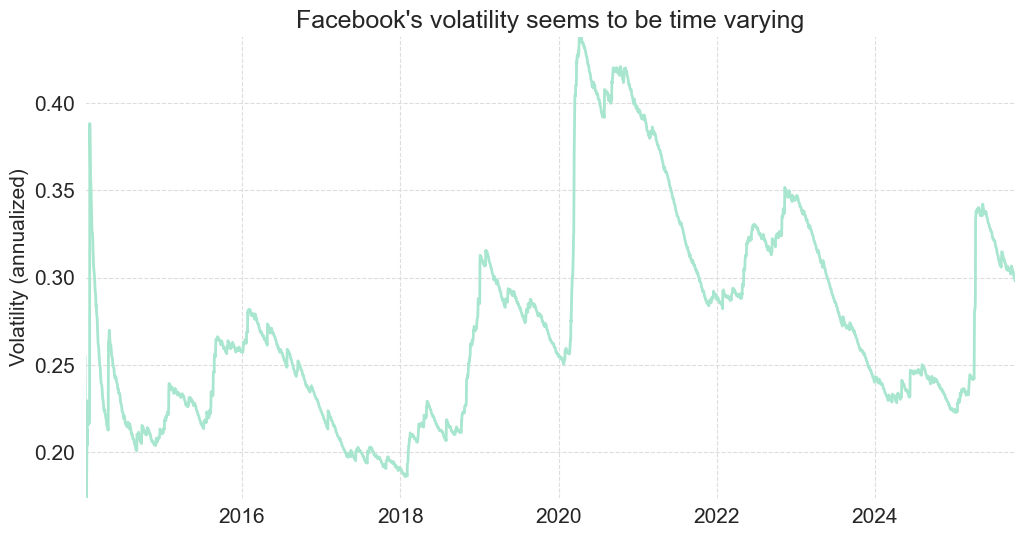

In [129]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(faang_adj_log_ret.index[1:, ], np.sqrt(cov_matrices[1:, 0, 0] * 250));
ax.set_title("Facebook's volatility seems to be time varying");
ax.set_ylabel("Volatility (annualized)");

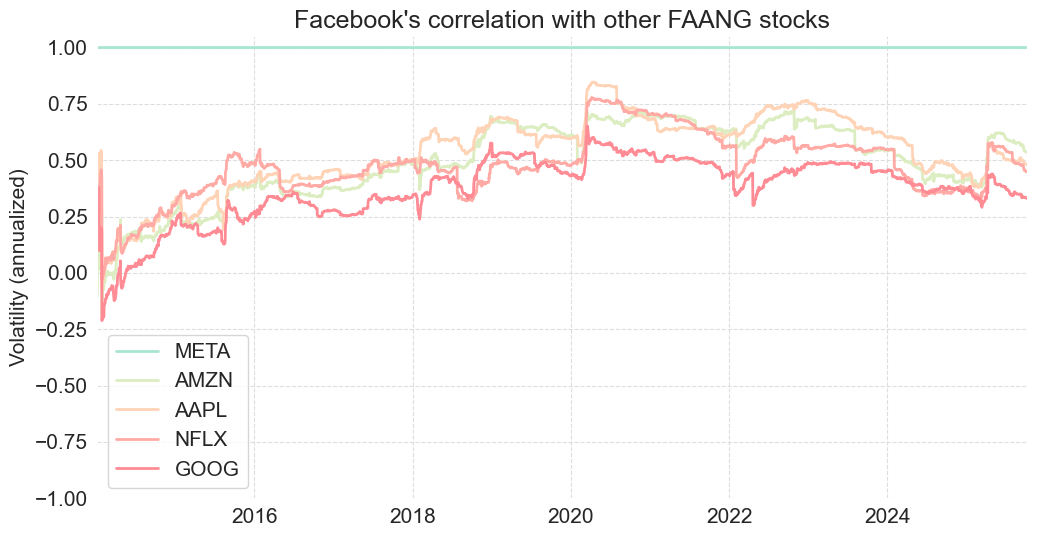

In [130]:
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(5):
    ax.plot(faang_adj_log_ret.index[2:, ], corr_matrices[1:, 0, i], label=tickers[i]);

ax.set_title("Facebook's correlation with other FAANG stocks");
ax.set_ylabel("Volatility (annualized)");
ax.legend()
ax.set_ylim([-1.0, 1.05]);

# References


## Articles

 [Ledoit and Wolf (2003), Improved estimation of the covariance matrix
of stock returns with an application to
portfolio selection](https://www.sciencedirect.com/science/article/abs/pii/S0927539803000070)

[Nyberg (2010)](https://onlinelibrary-wiley-com.esc-web.lib.cbs.dk:8443/doi/abs/10.1002/for.1161)

[Ardia, Bolliger, Boudt, Fleury (2017), The Impact of Covariance Misspecification in Risk-Based Portfolios](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2650644)

## Books

[Marcos M. Lopéz de Prado (2020), "Machine Learning for Asset Managers"](https://www.amazon.com/Machine-Learning-Managers-Elements-Quantitative/dp/1108792898)

[Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646)